In [2]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [3]:
b = phoebe.load("../estimations/aviles-data-bundle-saves/ebai-estimates")

In [4]:
# loading full Iturbide observations to compare results
import pandas as pd

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/culledObjData.csv"
iturbideObservations = pd.read_csv(CONCAT_OBSERVATIONS_CSV, index_col=0)

b.add_dataset('lc', dataset='lc_iturbide_full_raw', overwrite=True,
              times=iturbideObservations['julianDate'].to_numpy()*u.day, 
              fluxes=iturbideObservations['FLUX'].to_numpy(), sigmas=iturbideObservations['FERR'].to_numpy(),
			  pblum_mode="dataset-scaled")

<ParameterSet: 47 parameters | contexts: dataset, figure, compute, constraint>

In [5]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw', 'lc_iturbide_full_raw']
rawOptDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

plotAllDatasetsGroups = [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets]

def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	try:
		print('\t', "Iturbide (Aviles) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	except: pass

	try:
		print('\t', "Iturbide (Full) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_full_raw')))
	except: pass

	try:
		print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass

def printAllModelsChi2(b: phoebe.Bundle):
	for m in b.models:
		printChi2(b, m)

100%|██████████| 1964/1964 [03:08<00:00, 10.43it/s]
Sat, 18 Nov 2023 16:22 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


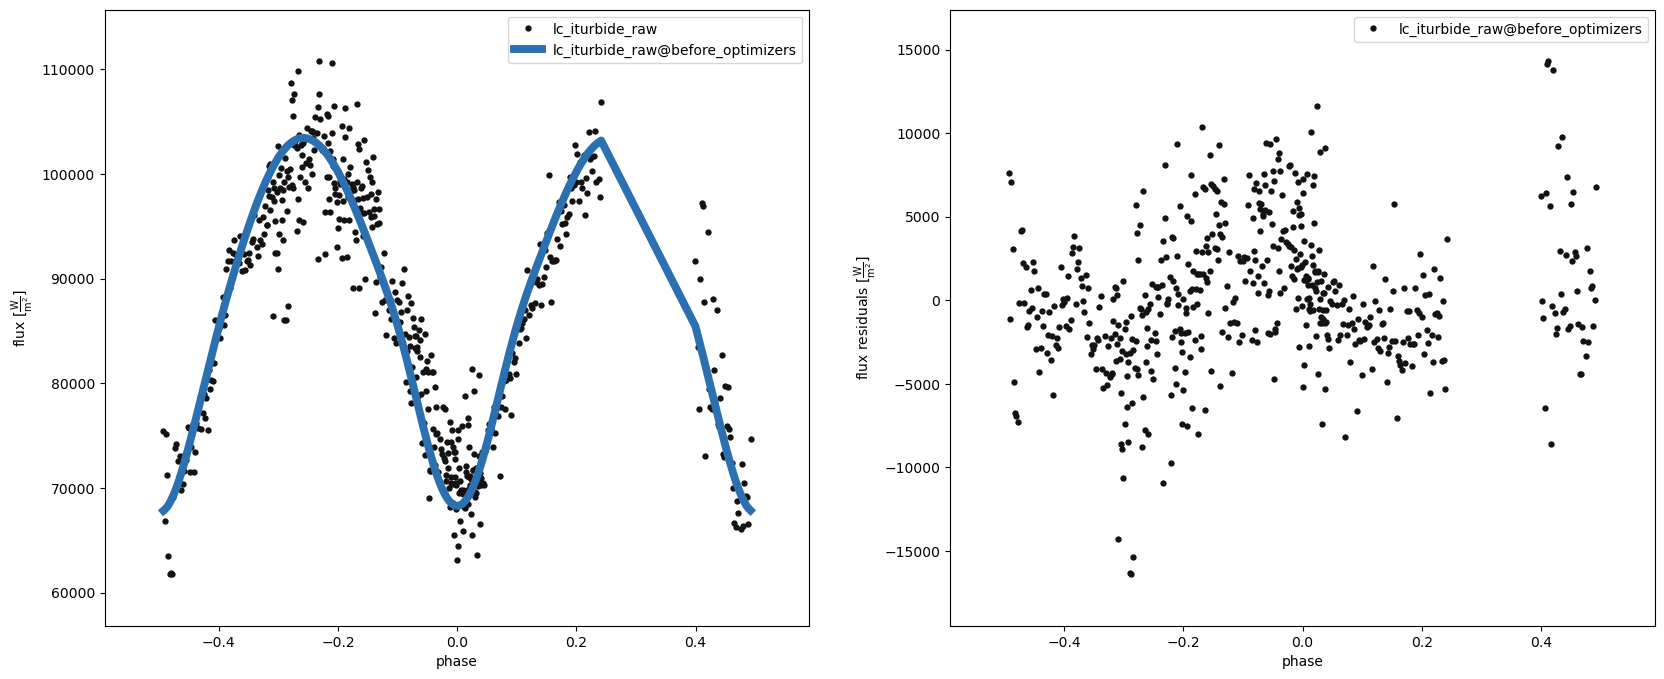

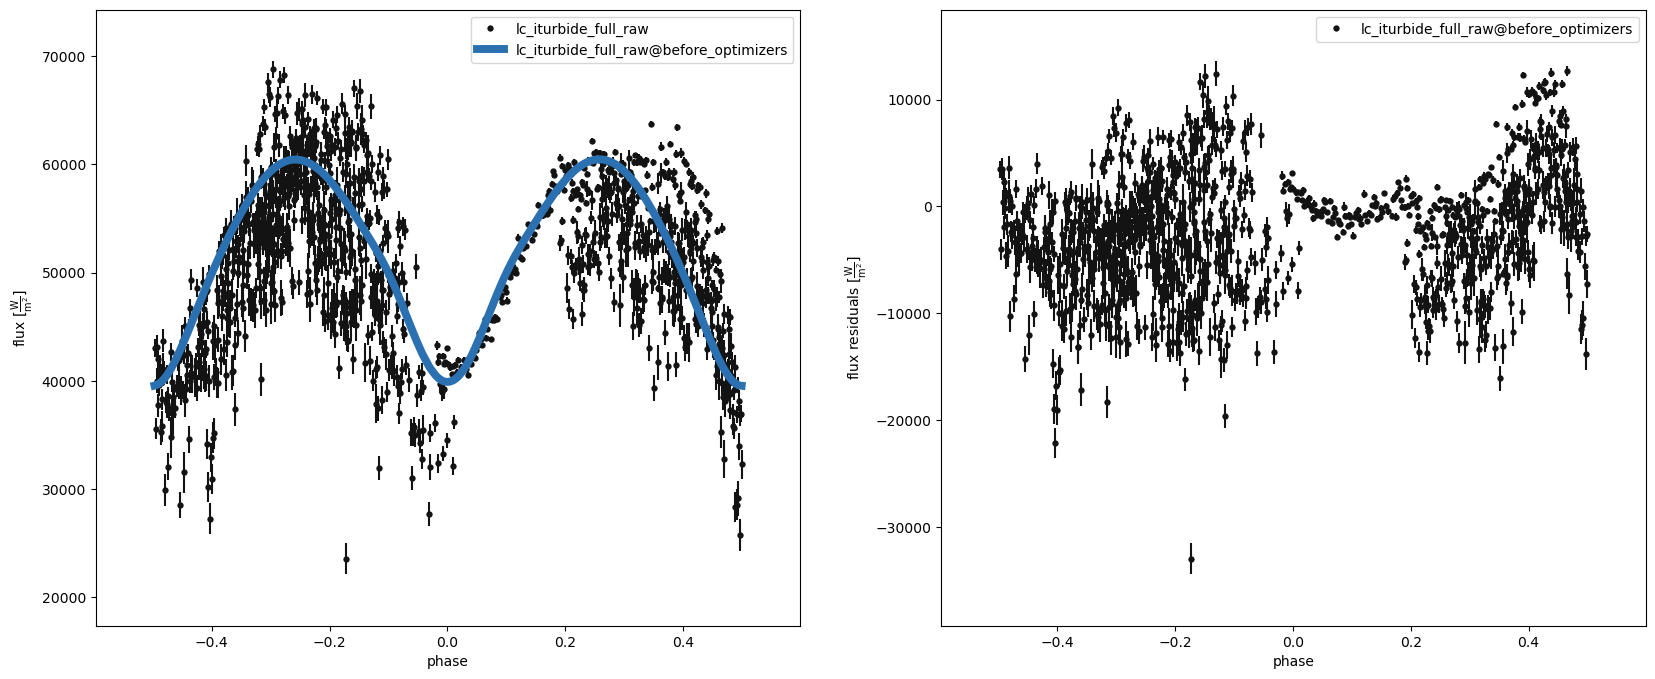

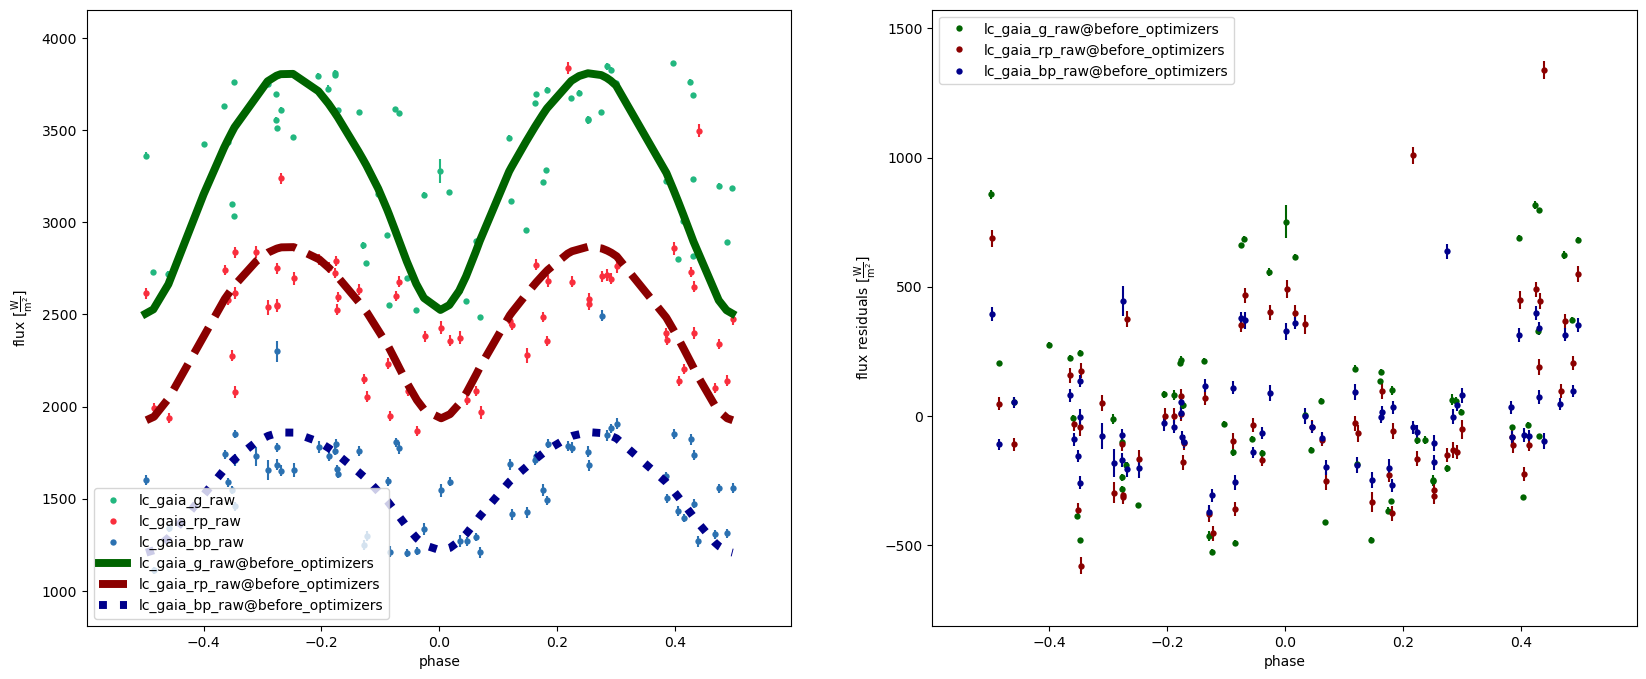

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079


In [6]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers', overwrite=True)

gen_utils.plotModelResidualsFigsize(b, (20,8), plotAllDatasetsGroups, model='before_optimizers')
printChi2(b, "before_optimizers")

## Inverting `q`

Inverting the mass ratio to obtain lower mass components; will re-optimize parameters according to this new assumption.

Flipping `sma@binary` constraint to keep low estimated masses.

In [7]:
b.flip_constraint(qualifier='mass', component='primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 3.3499999999999996 solRad>

In [8]:
print(b['q'])
print(b['mass'])
print(b['sma@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, incl@binary@component, asini@primary@component, requiv_max@primary@component, req

Sat, 18 Nov 2023 16:22 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Sat, 18 Nov 2023 16:22 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 1964/1964 [03:00<00:00, 10.88it/s]
Sat, 18 Nov 2023 16:25 BUNDL

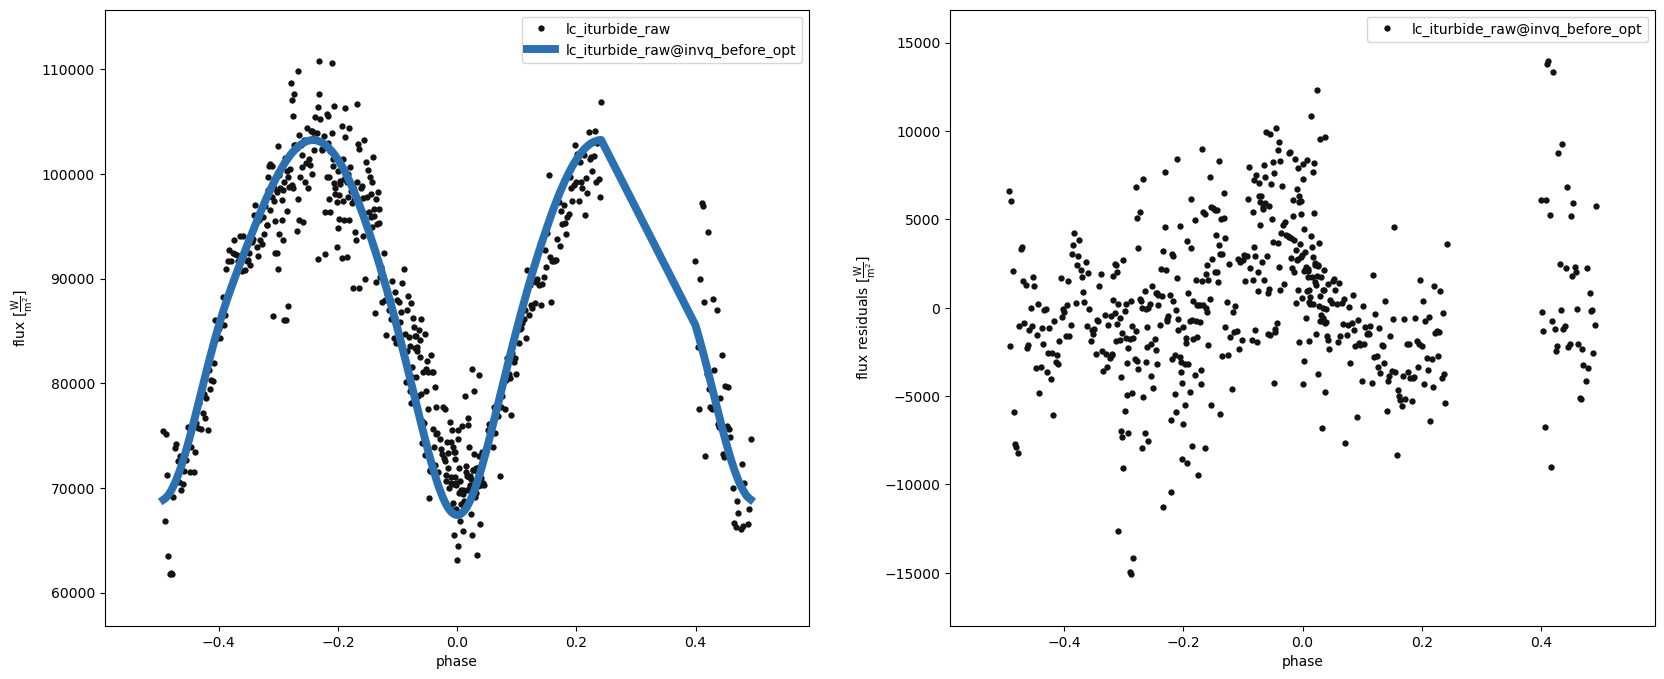

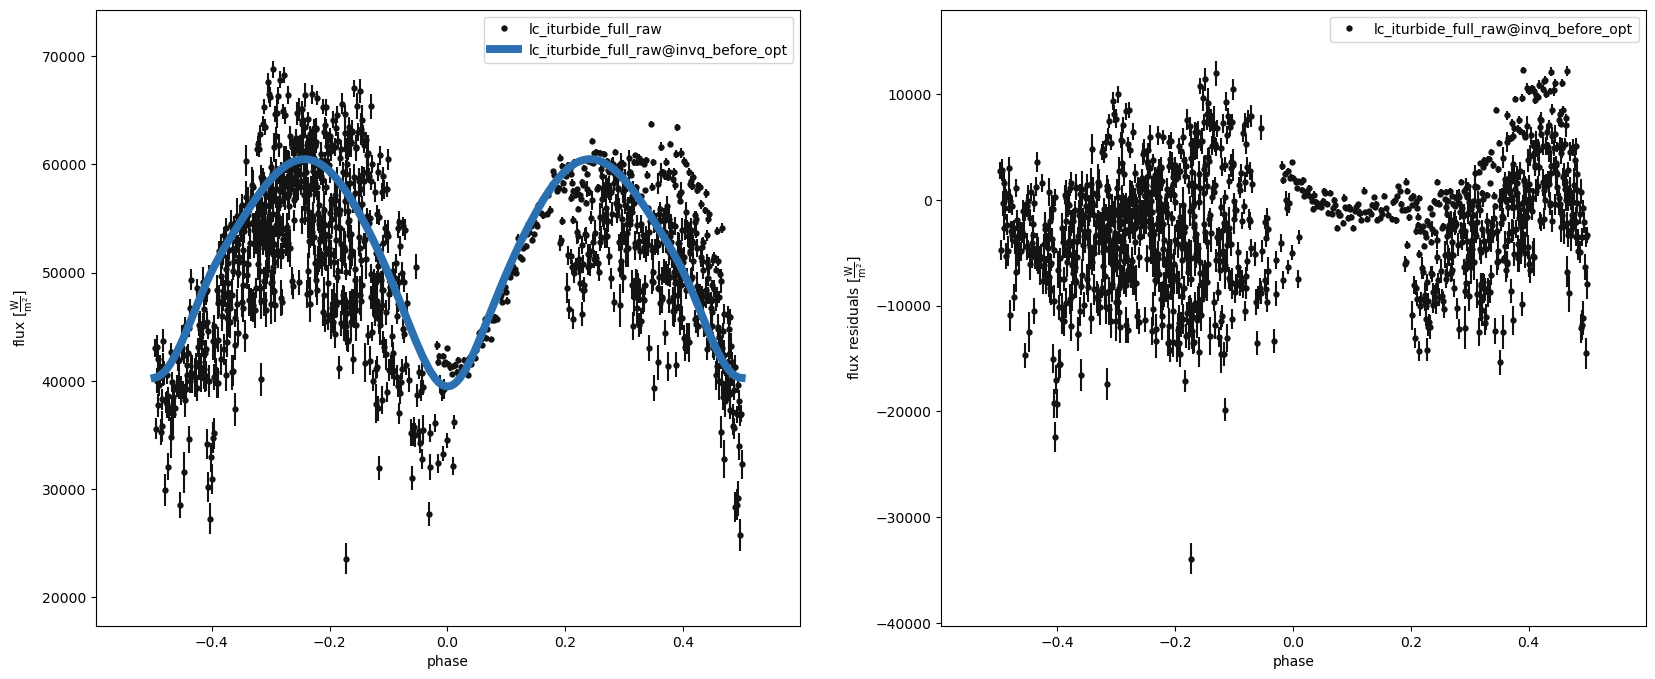

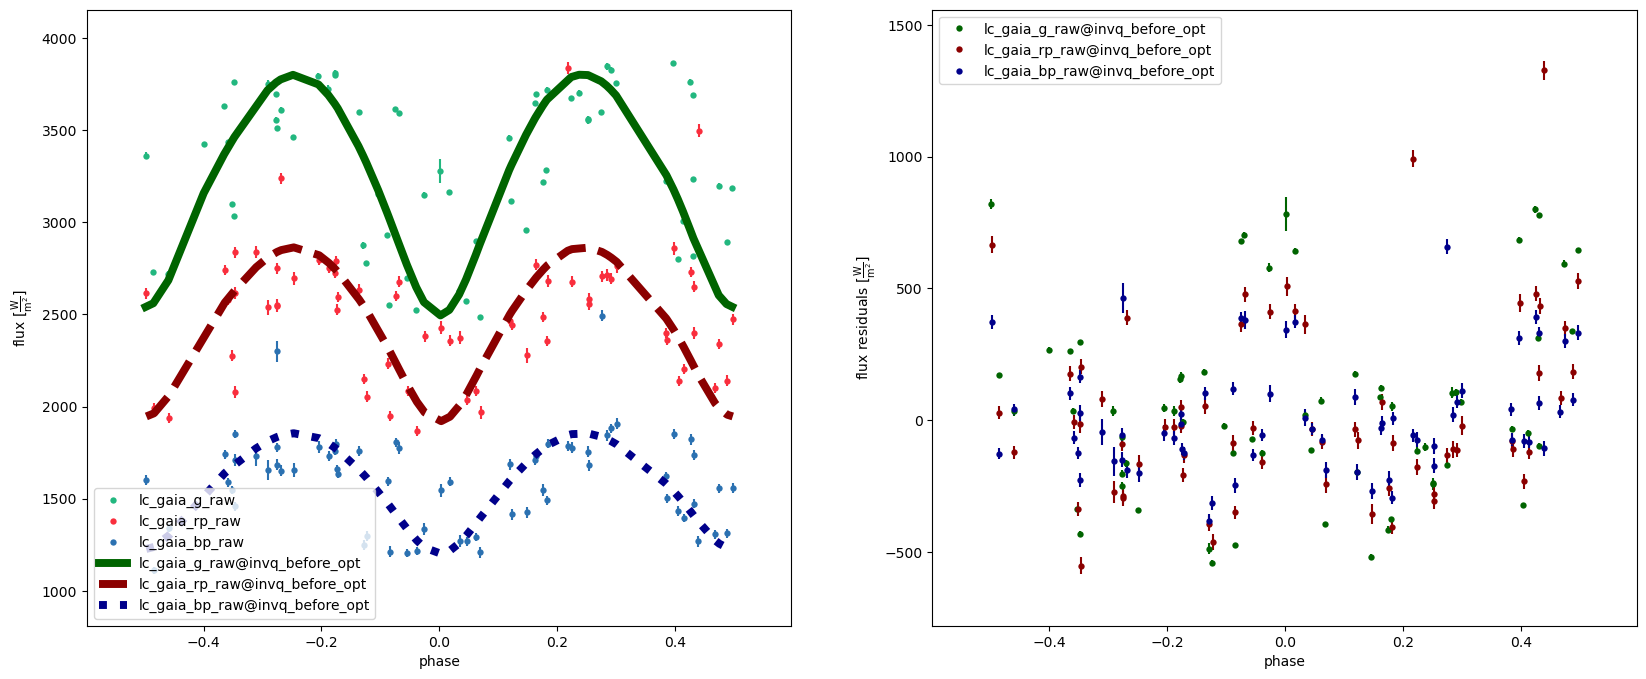

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714


In [9]:
b.set_value(qualifier='q', value=1/b.get_value(qualifier='q'))
b.run_compute(model='invq_before_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model="invq_before_opt")

printChi2(b, "before_optimizers")
printChi2(b, "invq_before_opt")

In [10]:
print(b['q'])
print(b['mass'])
print(b['sma@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 0.2861274842133835
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, incl@binary@component, asini@primary@component, requiv_max@primary@component, re

## Poro et al. (2021) Priors

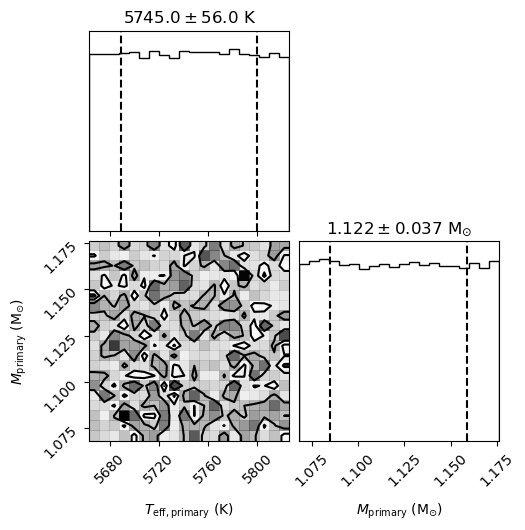

In [11]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Trimming the Bundle

Removing unused datasets and models from estimators to de-clutter bundle and decrease bundle size.

In [12]:
for m in b.models:
	if m.startswith('ebai'):
		b.remove_model(m)

for d in ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']:
	b.remove_dataset(d)

## Period and `t0_supconj`

Using solution from other optimizer, results should be about the same.

Adopted:
t0_supconj@binary@orbit@component = 0.07183 d
period@binary@orbit@component = 0.33354 d

Original values:
  t0_supconj@binary@orbit@component 0.06841024400254482 d
  period@binary@orbit@component 0.3335413827524847 d


100%|██████████| 1948/1948 [02:57<00:00, 11.00it/s]
Sat, 18 Nov 2023 16:29 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


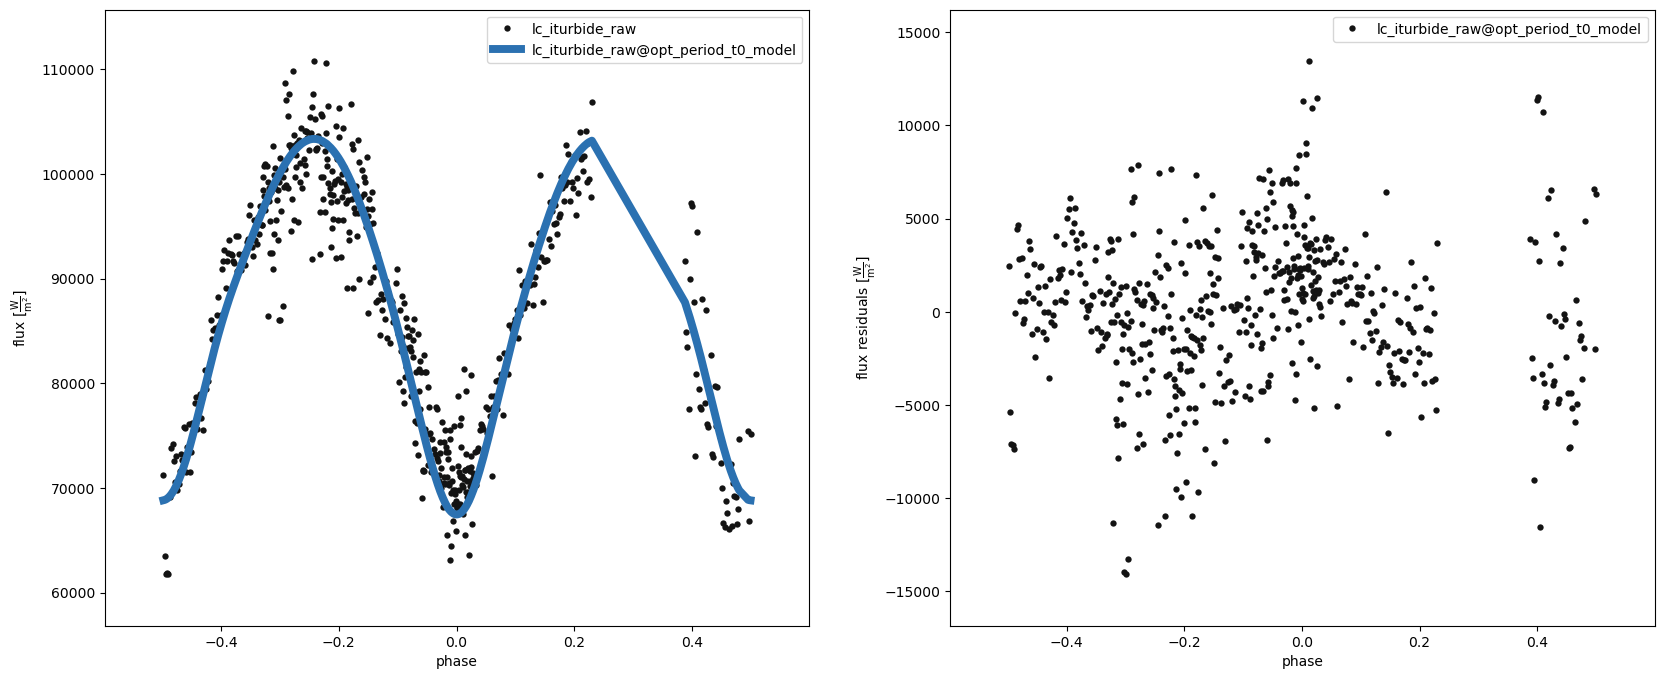

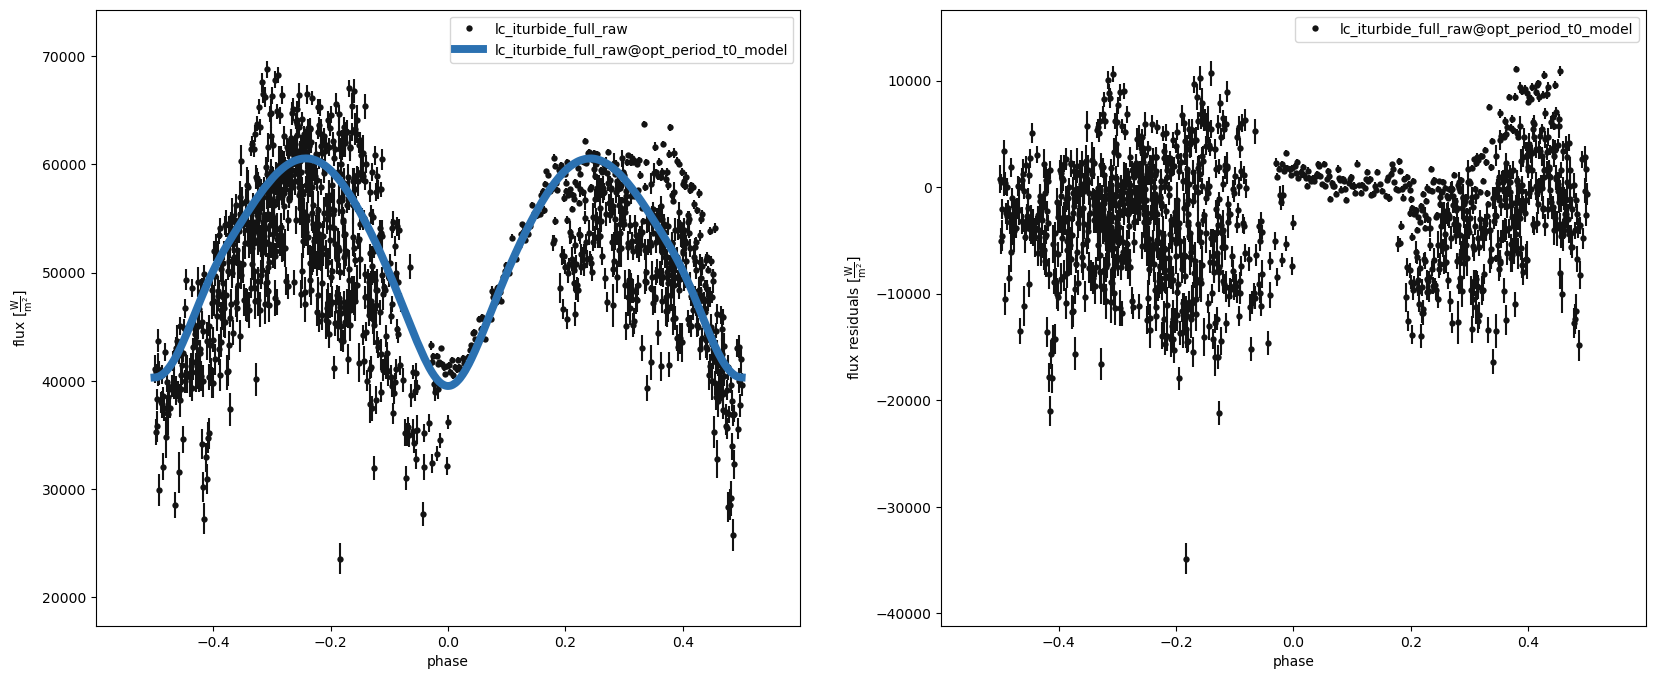

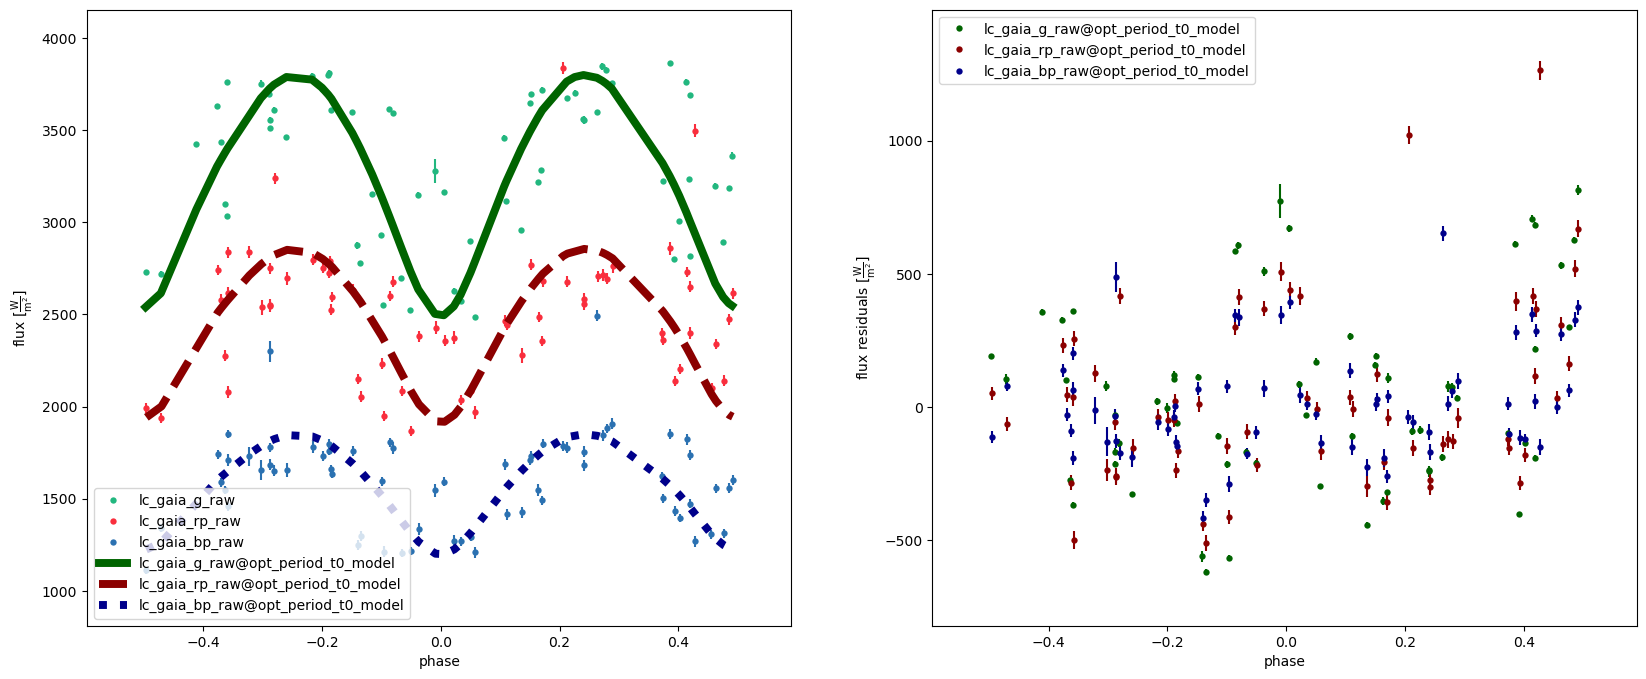

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_gaia_g_raw - 65242.71478786489
		 lc_gaia_rp_raw - 7409.450191021206
		 lc_gaia_bp_raw - 3597.234745568175


In [13]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./aviles-data-external-jobs/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

## Width and depth of eclipses

First pass at optimizing `teffratio`. Optimizing `fillout_factor` to give depth of eclipses (parametrization of radii).

In [14]:
%%script echo "skipping; already created and ran the optimizer"
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)

skipping; already created and ran the optimizer


Adopted:
teffratio@binary@orbit@component = 1.02064 
fillout_factor@contact_envelope@envelope@component = 0.20343 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 1964/1964 [03:17<00:00,  9.95it/s]
Sat, 18 Nov 2023 16:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


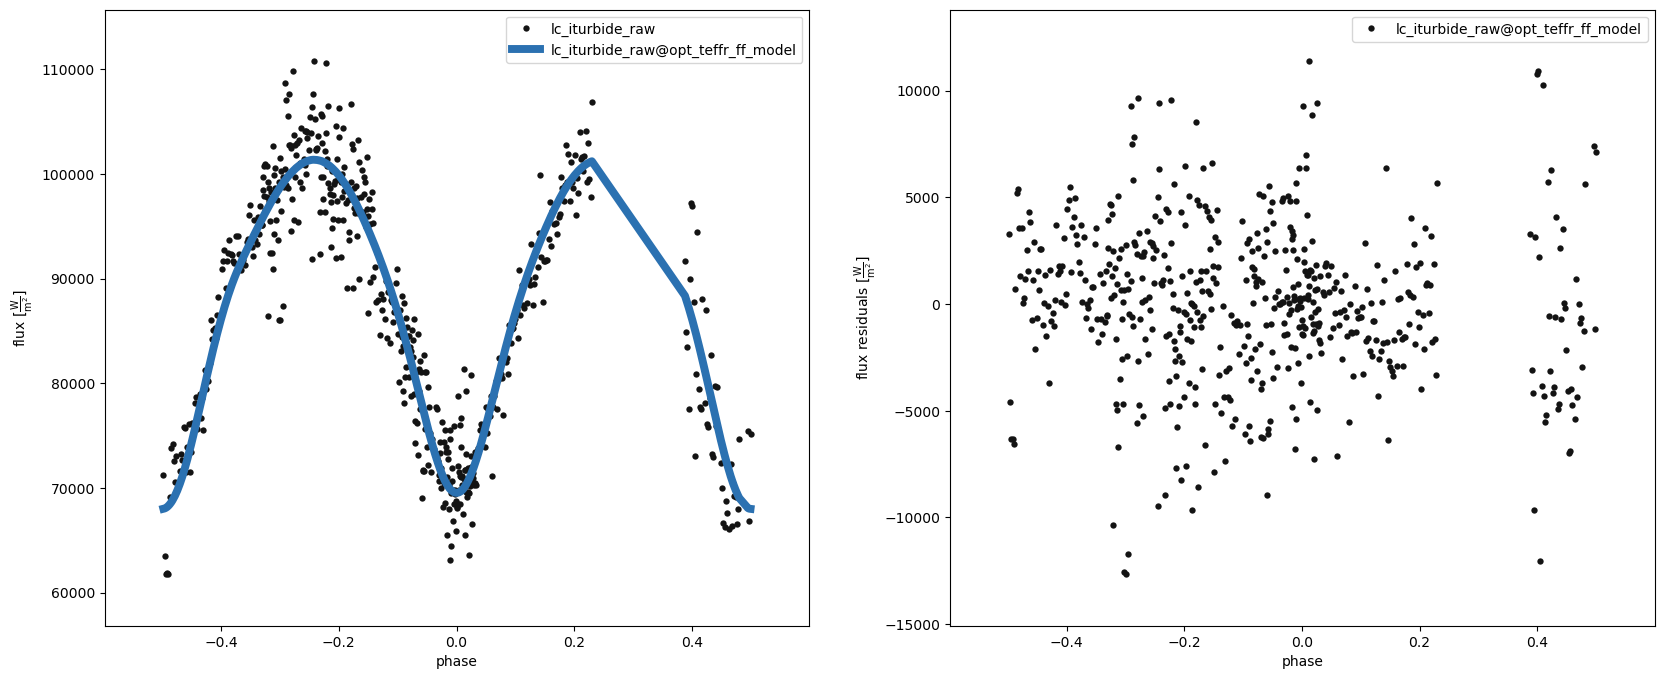

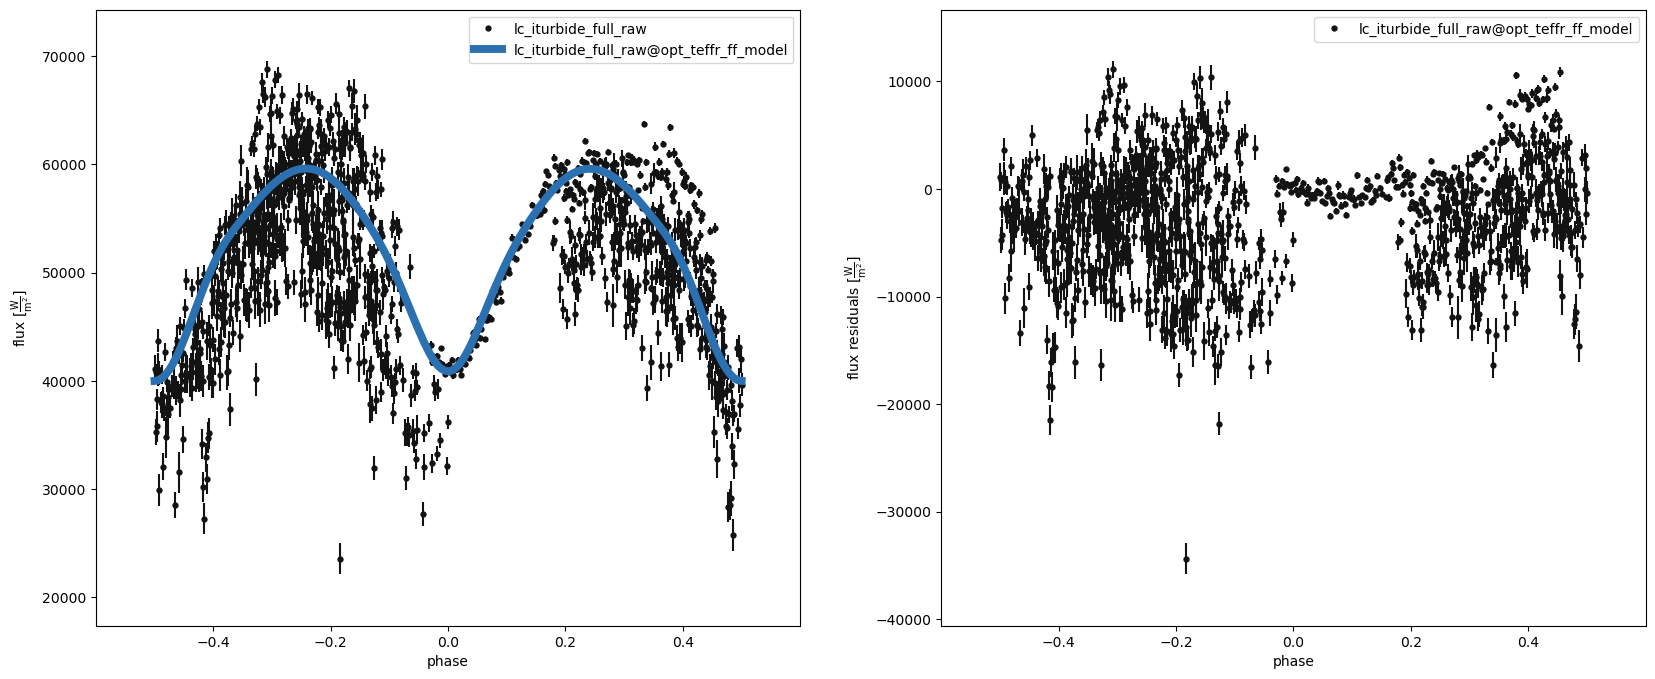

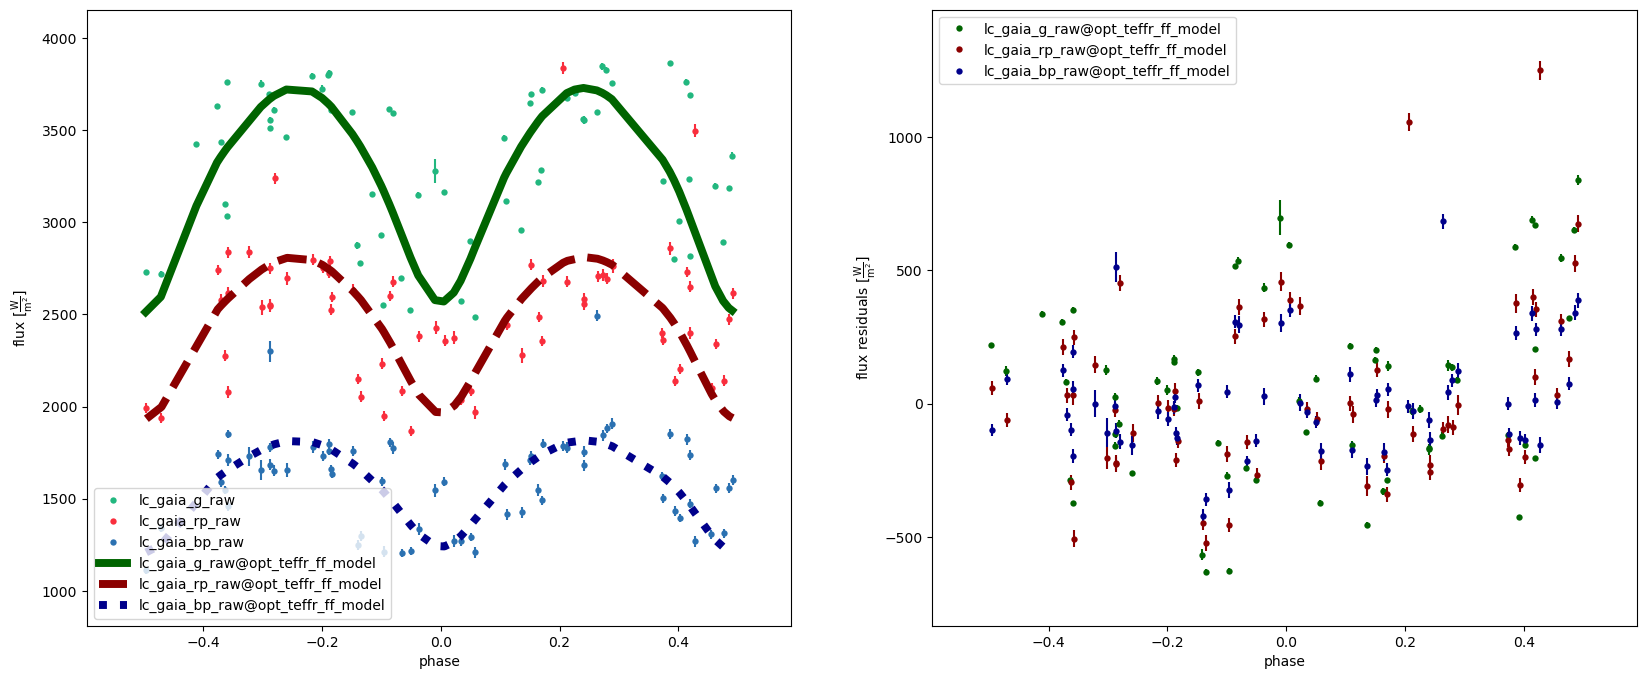

full_default
-------------------------------------
raw_model
-------------------------------------
	 Iturbide (Aviles) - 526346844631.68317
	 Gaia - 574823.2231559469
		 lc_gaia_g_raw - 499130.5358300727
		 lc_gaia_rp_raw - 45880.46343980033
		 lc_gaia_bp_raw - 29812.223886073876
before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_ga

In [15]:
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_teffr_ff_solution", reset_params=False, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model=computeModelName)
printAllModelsChi2(b)

## `q` and Inclination

Testing optimizing for mass ratio and system inclination.

In [16]:
%%script echo "skipping; already created the optimizers"
opt_utils.optimize_params(b, ['q', 'incl@binary'], "q_incl", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)
opt_utils.optimize_params(b, ['incl@binary'], "incl", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)
opt_utils.optimize_params(b, ['q'], "q", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)

skipping; already created the optimizers


In [17]:
%%script echo "skipping; not adopting"
# q only
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_q_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model=computeModelName)
printAllModelsChi2(b)

skipping; not adopting


Adopted:
incl@binary@orbit@component = 68.77717 deg

Original values:
  incl@binary@orbit@component 71.94760460889874 deg


100%|██████████| 1964/1964 [03:17<00:00,  9.94it/s]
Sat, 18 Nov 2023 16:36 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


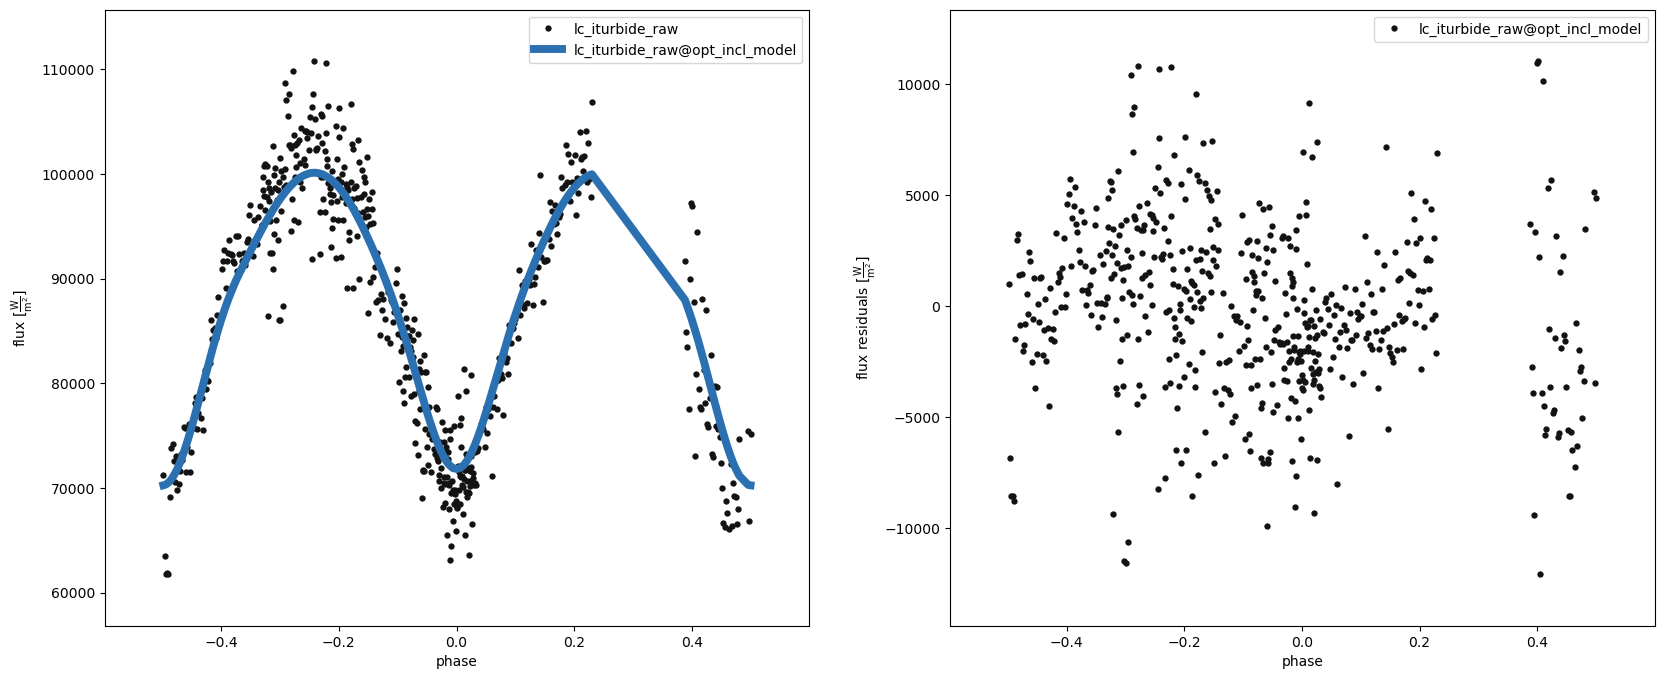

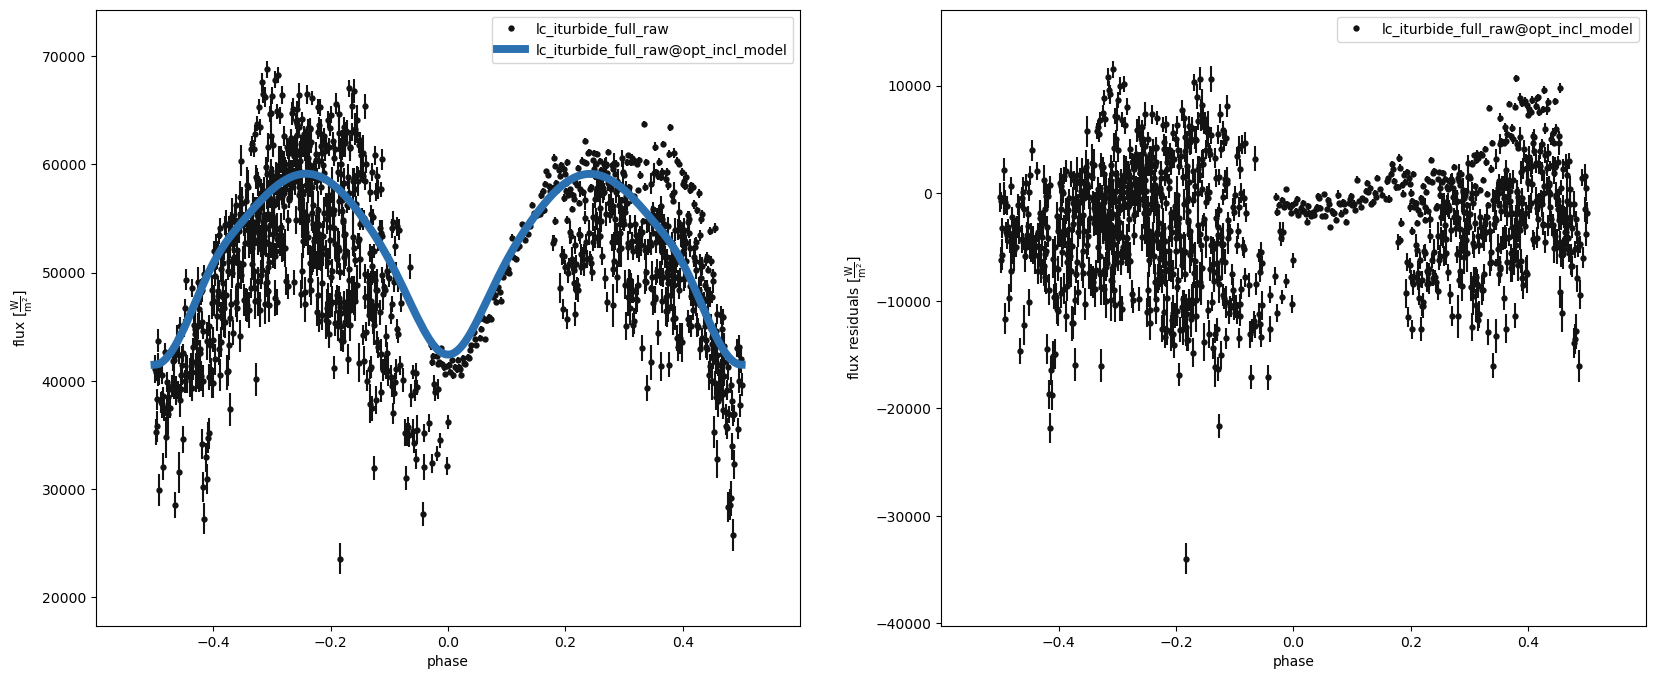

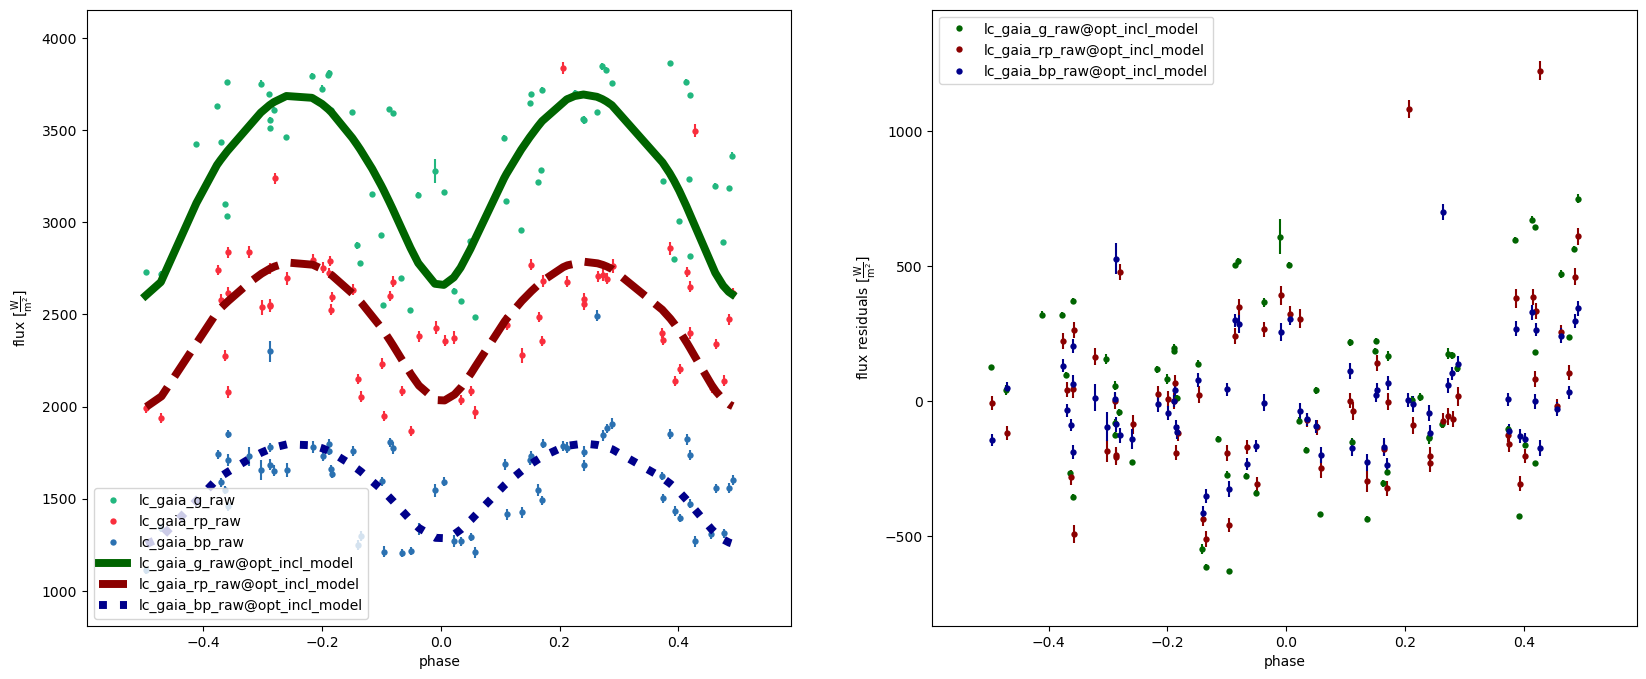

full_default
-------------------------------------
raw_model
-------------------------------------
	 Iturbide (Aviles) - 526346844631.68317
	 Gaia - 574823.2231559469
		 lc_gaia_g_raw - 499130.5358300727
		 lc_gaia_rp_raw - 45880.46343980033
		 lc_gaia_bp_raw - 29812.223886073876
before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_ga

In [18]:
# incl only
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_incl_solution", reset_params=False, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model=computeModelName)
printAllModelsChi2(b)

In [19]:
%%script echo "skipping; not adopting"
# incl and q
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_q_incl_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model=computeModelName)
printAllModelsChi2(b)

skipping; not adopting


## Adjusting Temperatures and Luminosities

Component temperatures adjusted based on Gaia light curves, preserving color information using `dataset-scaled` light curves for $G_{RP}$ and $G_{BP}$, scaled to
$G$ Gaia light curve. 

Iturbide passband luminosity determined independently.

In [20]:
pb_backup = b.copy()

In [21]:
%%script echo "skip unless backup restore is needed"
b = pbBackup.copy()

skip unless backup restore is needed


100%|██████████| 1948/1948 [03:05<00:00, 10.51it/s]
Sat, 18 Nov 2023 16:39 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


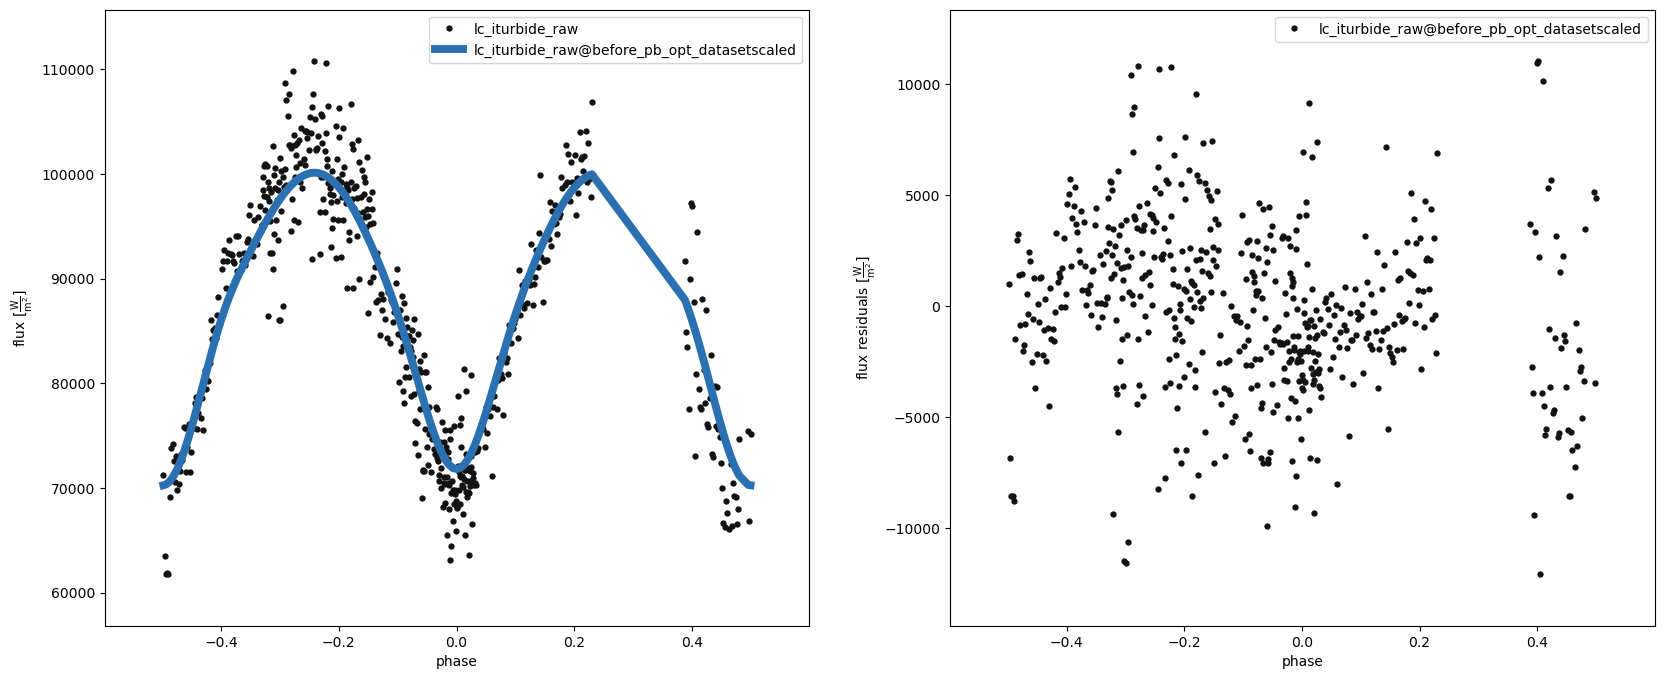

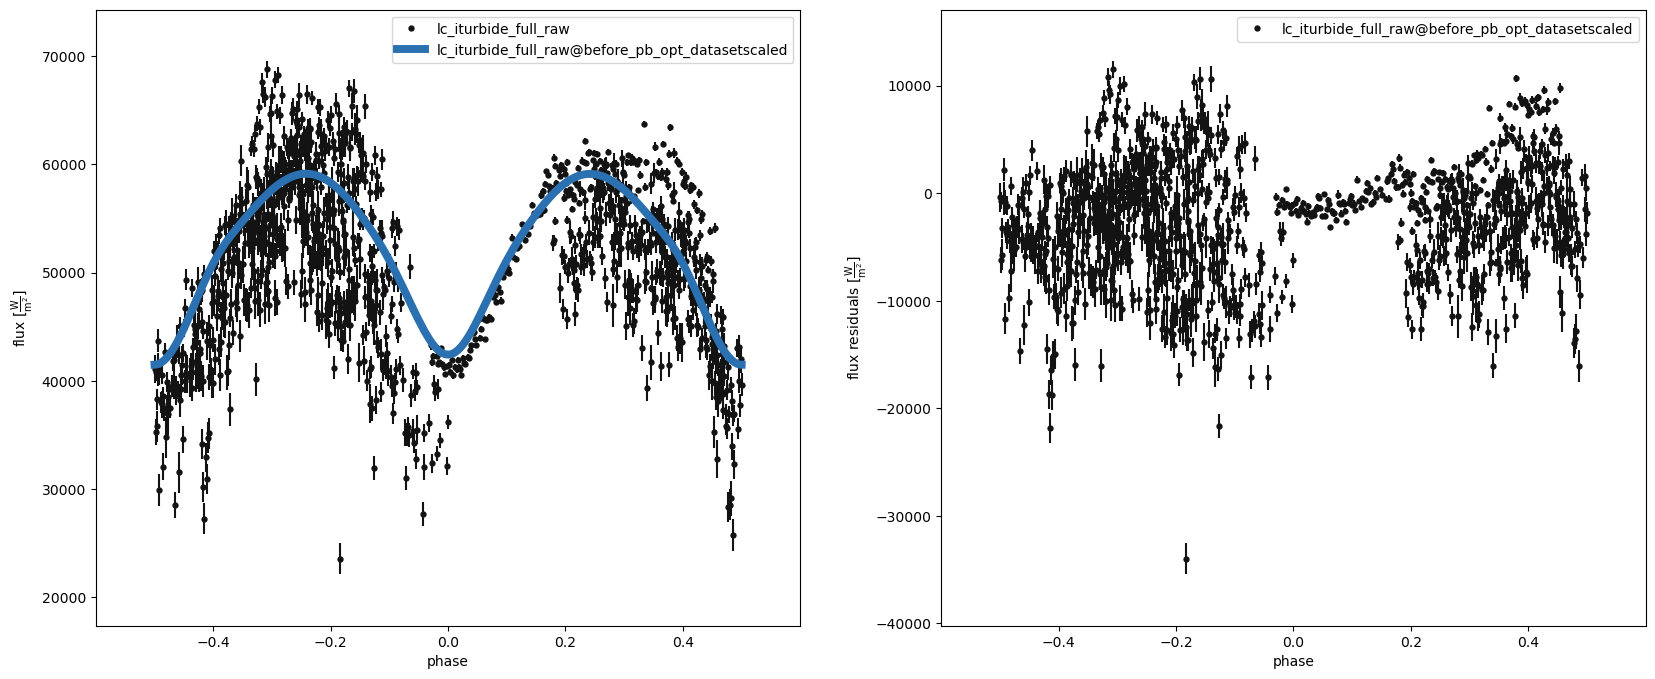

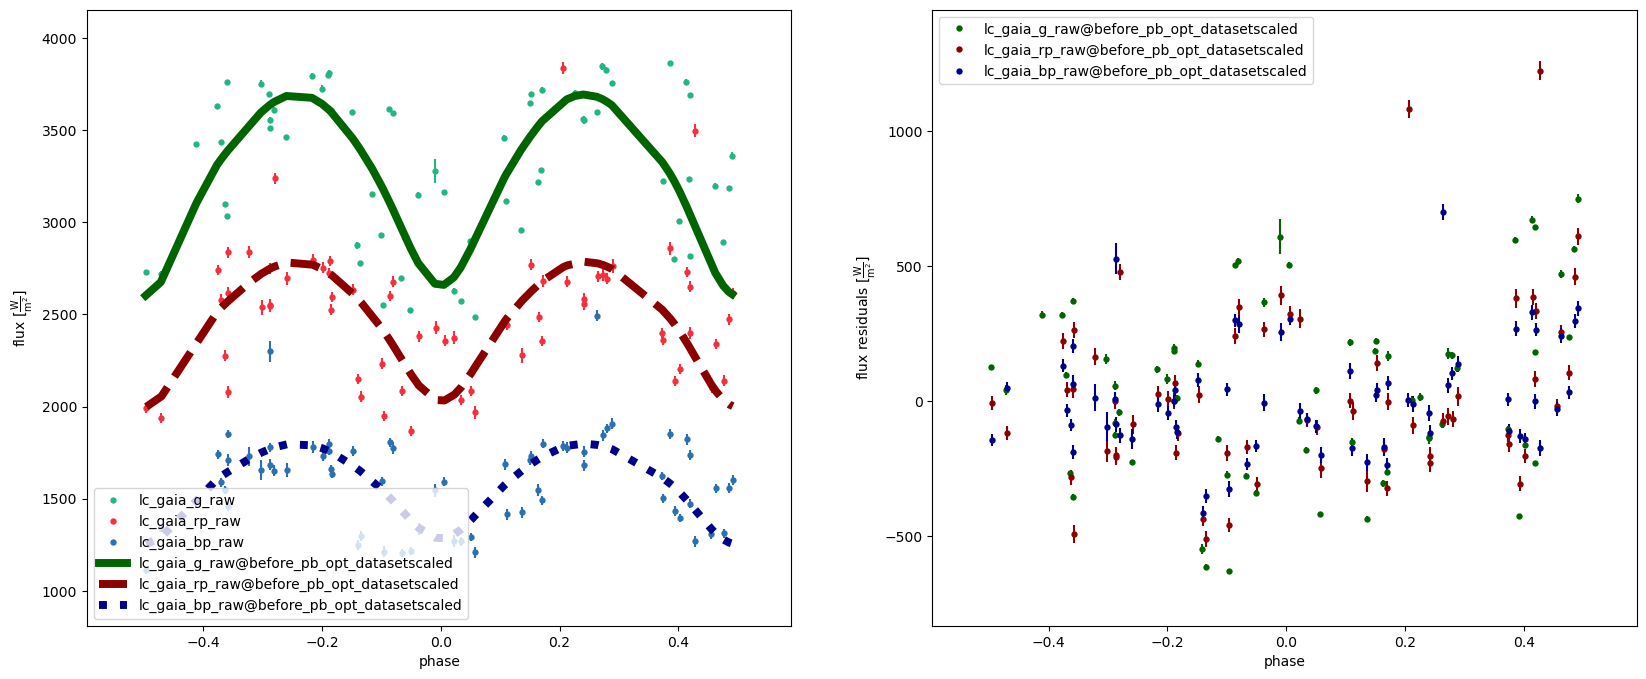

In [22]:
gen_utils.abilitateDatasets(b, allRawDatasets, False)
b.run_compute(model='before_pb_opt_datasetscaled')
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=plotAllDatasetsGroups, model='before_pb_opt_datasetscaled')

In [23]:
b.set_value_all(qualifier='pblum_mode', dataset=['lc_iturbide_raw', 'lc_iturbide_full_raw', 'lc_gaia_g_raw'], value='component-coupled')

# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

In [24]:
print(b['teff'])
print(b['teffratio'])
print(b['pblum'])

ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 6123.846272180199 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 1.0206410453633663
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

ParameterSet: 3 parameters
   pblum@primary@lc_iturbide_r...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W
   pblum@primary@lc_iturbide_f...: 12.566370614359172 W


In [25]:
%%script echo "skipping; already optimized"

# first couple of iterations to get gaia pblum close enough for follow-up optimizer
# not exporting it since it's a very small, quick optimizer (~10s per iteration)
opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw'], "init_pbgaia", export=False, datasets=['lc_gaia_g_raw'], maxiter=100)
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, label="init_pbgaia", plot=False,reset_params=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [rawGaiaDatasets], model=computeModelName)

skipping; already optimized


In [26]:
teffPrimDist = b.get_value(qualifier='teff', component='primary', context='distribution')
opt_utils.optimize_params(b, ['teff@primary', 'teffratio', 'pblum@primary@lc_gaia_g_raw'], "tprim_tratio_pbgaia", 
						  export=True, subfolder="poro-aviles-invq", datasets=rawGaiaDatasets, maxiter=1000,
						  initial_values={'teff@primary': teffPrimDist.sample()})
print(b['teff'])

External Solver: ./external-jobs/poro-aviles-invq/optimizer.nelder_mead_opt_tprim_tratio_pbgaia.py ./results/opt_tprim_tratio_pbgaia_solution
ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 6123.846272180199 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


Adopted:
teff@primary@star@component = 4138.43088 K
teffratio@binary@orbit@component = 0.94931 
pblum@primary@lc_gaia_g_raw@lc@dataset = 34979.80077 W

Original values:
  teff@primary@star@component 6000.0 K
  teffratio@binary@orbit@component 1.0206410453633663
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 213/213 [00:22<00:00,  9.57it/s]


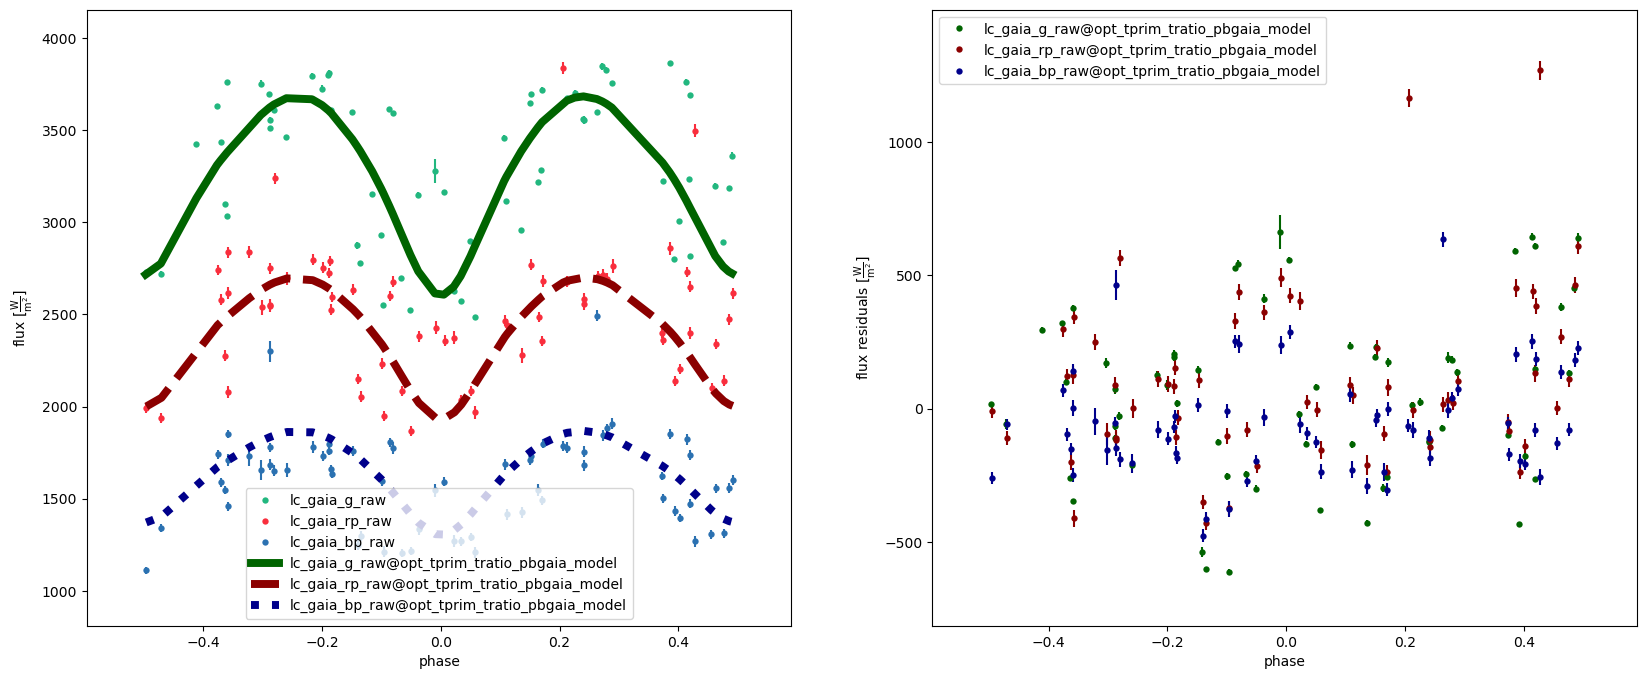

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

full_default
-------------------------------------
raw_model
-------------------------------------
	 Iturbide (Aviles) - 526346844631.68317
	 Gaia - 574823.2231559469
		 lc_gaia_g_raw - 499130.5358300727
		 lc_gaia_rp_raw - 45880.46343980033
		 lc_gaia_bp_raw - 29812.223886073876
before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_ga

In [27]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_tprim_tratio_pbgaia_solution", reset_params=False, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), datasetGroups=[rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)
printAllModelsChi2(b)

### Iturbide passband luminosity

In [28]:
%%script echo "skipping; already optimized"
opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_raw'], 'pb_iturbide_aviles', export=True, subfolder='poro-aviles-invq', datasets=['lc_iturbide_raw'], maxiter=100)
opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_full_raw'], 'pb_iturbide_full', export=True, subfolder='poro-aviles-invq', datasets=['lc_iturbide_full_raw'], maxiter=100)

skipping; already optimized


Adopted:
pblum@primary@lc_iturbide_raw@lc@dataset = 959718.38624 W

Original values:
  pblum@primary@lc_iturbide_raw@lc@dataset 12.566370614359172 W


100%|██████████| 566/566 [00:56<00:00, 10.06it/s]


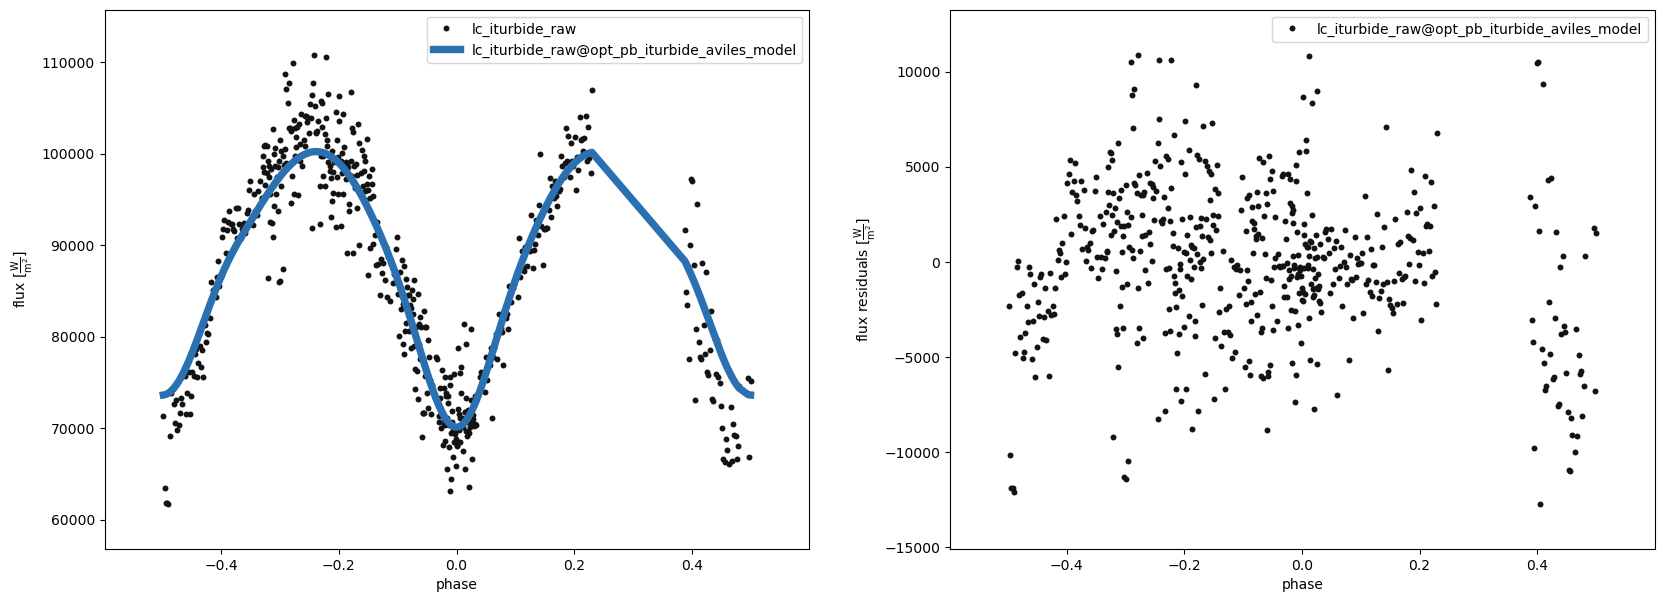

before_pb_opt_datasetscaled
-------------------------------------
	 Iturbide (Aviles) - 8160081048.740252
	 Iturbide (Full) - 55354.404931317185
	 Gaia - 68954.57332895407
		 lc_gaia_g_raw - 58765.11541125461
		 lc_gaia_rp_raw - 6769.439720257855
		 lc_gaia_bp_raw - 3420.0181974416114
opt_pb_iturbide_aviles_model
-------------------------------------
	 Iturbide (Aviles) - 8861945173.751333


In [29]:
# aviles LC
gen_utils.abilitateDatasets(b, ['lc_iturbide_raw'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_pb_iturbide_aviles_solution", plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 7), ['lc_iturbide_raw'], model=computeModelName)

printChi2(b, 'before_pb_opt_datasetscaled')
printChi2(b, computeModelName)

Sat, 18 Nov 2023 16:42 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_pb_iturbide_full_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
pblum@primary@lc_iturbide_full_raw@lc@dataset = 567161.63127 W

Original values:
  pblum@primary@lc_iturbide_full_raw@lc@dataset 12.566370614359172 W


100%|██████████| 1217/1217 [02:07<00:00,  9.51it/s]


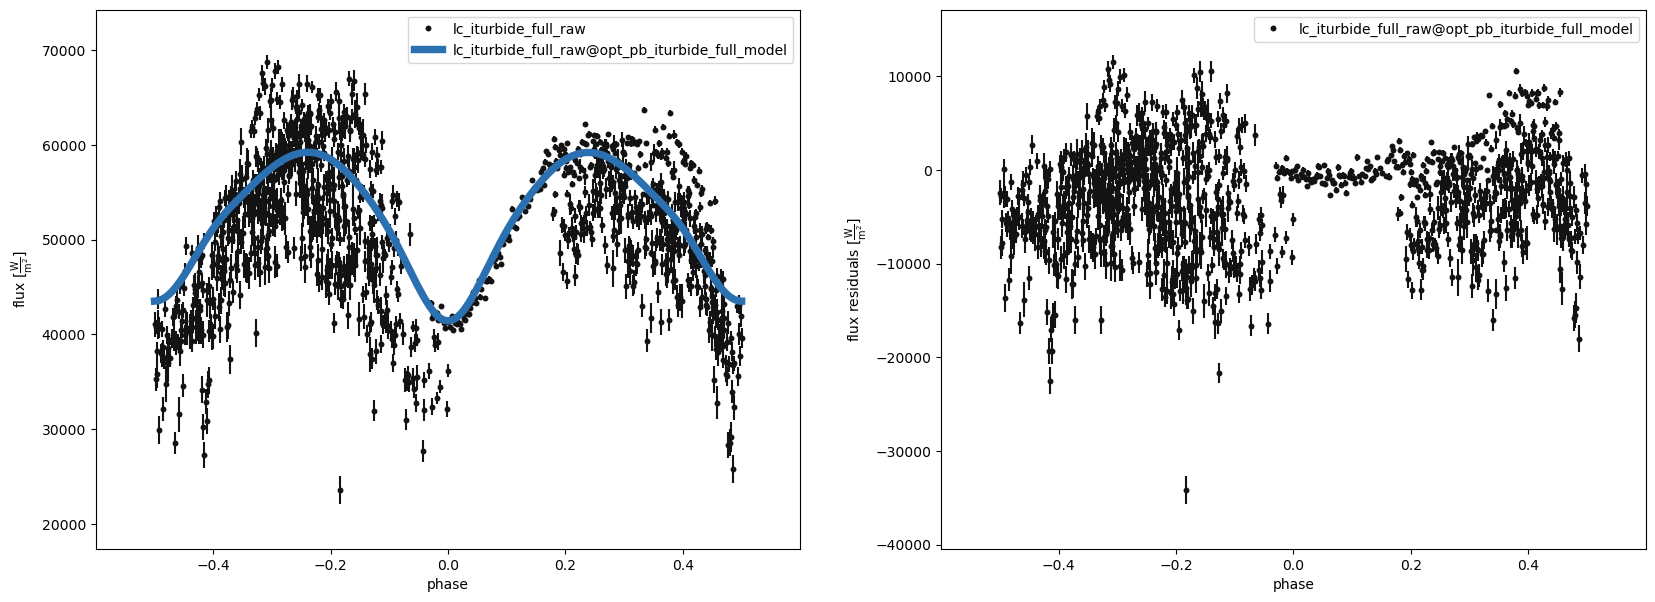

before_pb_opt_datasetscaled
-------------------------------------
	 Iturbide (Aviles) - 8160081048.740252
	 Iturbide (Full) - 55354.404931317185
	 Gaia - 68954.57332895407
		 lc_gaia_g_raw - 58765.11541125461
		 lc_gaia_rp_raw - 6769.439720257855
		 lc_gaia_bp_raw - 3420.0181974416114
opt_pb_iturbide_full_model
-------------------------------------
	 Iturbide (Full) - 53752.020493084914


In [30]:
# full iturbide LC
gen_utils.abilitateDatasets(b, ['lc_iturbide_full_raw'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_pb_iturbide_full_solution", plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 7), ['lc_iturbide_full_raw'], model=computeModelName)

printChi2(b, 'before_pb_opt_datasetscaled')
printChi2(b, computeModelName)

## Differential Evolution Optimization

Running a final differential evolution optimizer to get closer to optimal values. Trying setting generous wide bounds.

Optimizing using only Gaia LCs. Depending on results, will run another optimizer on the Iturbide LCs, if parameters change drastically.

In [31]:
print(b.get_adjustable_parameters())

ParameterSet: 46 parameters
                  distance@system: 1.0 m
                    vgamma@system: 0.0 km / s
                        Av@system: 0.0
                        Rv@system: 3.1
           teff@primary@component: 4138.4308834938365 K
        syncpar@primary@component: 1.0
      gravb_bol@primary@component: 0.32
   irrad_frac_refl_bol@primary...: 0.6
           mass@primary@component: 1.0087816199638129 solMass
      syncpar@secondary@component: 1.0
    gravb_bol@secondary@component: 0.32
   irrad_frac_refl_bol@seconda...: 0.6
          period@binary@component: 0.33354138280951534 d
            dpdt@binary@component: 0.0 s / yr
            per0@binary@component: 0.0 deg
          dperdt@binary@component: 0.0 deg / yr
             ecc@binary@component: 0.0
      t0_supconj@binary@component: 0.07183187311538936 d
            incl@binary@component: 68.77716874302344 deg
               q@binary@component: 0.2861274842133835
         long_an@binary@component: 0.0 deg
   abun@c

In [32]:
b.add_distribution({
	'teff@primary': phoebe.uniform_around(width=500),
	'teffratio': phoebe.uniform_around(width=0.1),
	'mass@primary': phoebe.uniform_around(width=0.5),
	'q': phoebe.uniform(low=0.25, high=0.4),
	'fillout_factor': phoebe.uniform(low=0.203, high=0.5),
	'pblum@primary@lc_gaia_g_raw': phoebe.uniform_around(width=10_000)
}, distribution='de_gaia_bounds', overwrite_all=True)

opt_utils.optimize_params(b, label="de_opt", optimizer="optimizer.differential_evolution", datasets=rawGaiaDatasets,
		fit_twigs=['teff@primary', 'teffratio', 'mass@primary', 'q', 'fillout_factor', 'pblum@primary@lc_gaia_g_raw'],
		export=True, subfolder="aviles-invq", maxiter=1000, polish=False, bounds=['de_gaia_bounds'])

External Solver: ./external-jobs/aviles-invq/optimizer.differential_evolution_opt_de_opt.py ./results/opt_de_opt_solution


('opt_de_opt', 'opt_de_opt_solution')

In [33]:
# TODO: maybe re-run this, forgot to include pblum for iturbide LCs :/
# including iturbide pblum to optimize; otherwise, chi2 grows quite a bit
b.add_distribution({
	'teff@primary': phoebe.uniform_around(width=500),
	'teffratio': phoebe.uniform_around(width=0.1),
	'mass@primary': phoebe.uniform_around(width=0.5),
	'q': phoebe.uniform(low=0.25, high=0.4),
	'fillout_factor': phoebe.uniform(low=0.203, high=0.5),
	'pblum@primary@lc_gaia_g_raw': phoebe.uniform_around(width=10_000),
	'pblum@primary@lc_iturbide_full_raw': phoebe.uniform_around(width=15_000),
	'pblum@primary@lc_iturbide_raw': phoebe.uniform_around(width=15_000)
}, distribution='de_bounds', overwrite_all=True)

opt_utils.optimize_params(b, label="de_opt_full", optimizer="optimizer.differential_evolution", datasets=allRawDatasets,
		fit_twigs=['teff@primary', 'teffratio', 'mass@primary', 'q', 'fillout_factor', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_full_raw', 'pblum@primary@lc_iturbide_raw'],
		export=True, subfolder="aviles-invq", maxiter=100, polish=False, bounds=['de_bounds'])

External Solver: ./external-jobs/aviles-invq/optimizer.differential_evolution_opt_de_opt_full.py ./results/opt_de_opt_full_solution


('opt_de_opt_full', 'opt_de_opt_full_solution')

In [34]:
de_backup = b.copy()

In [35]:
b = de_backup.copy()

Adopted:
teff@primary@star@component = 4094.97051 K
teffratio@binary@orbit@component = 0.94154 
mass@primary@star@component = 0.99461 solMass
q@binary@orbit@component = 0.25423 
fillout_factor@contact_envelope@envelope@component = 0.35673 
pblum@primary@lc_gaia_g_raw@lc@dataset = 35899.40426 W

Original values:
  teff@primary@star@component 4138.4308834938365 K
  teffratio@binary@orbit@component 0.9493072392967905
  mass@primary@star@component 1.0087816199638129 solMass
  q@binary@orbit@component 0.2861274842133835
  fillout_factor@contact_envelope@envelope@component 0.2034325452229504
  pblum@primary@lc_gaia_g_raw@lc@dataset 34979.800770998816 W


Sat, 18 Nov 2023 16:45 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Sat, 18 Nov 2023 16:45 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 1964/1964 [03:06<00:00, 10.55it/s]


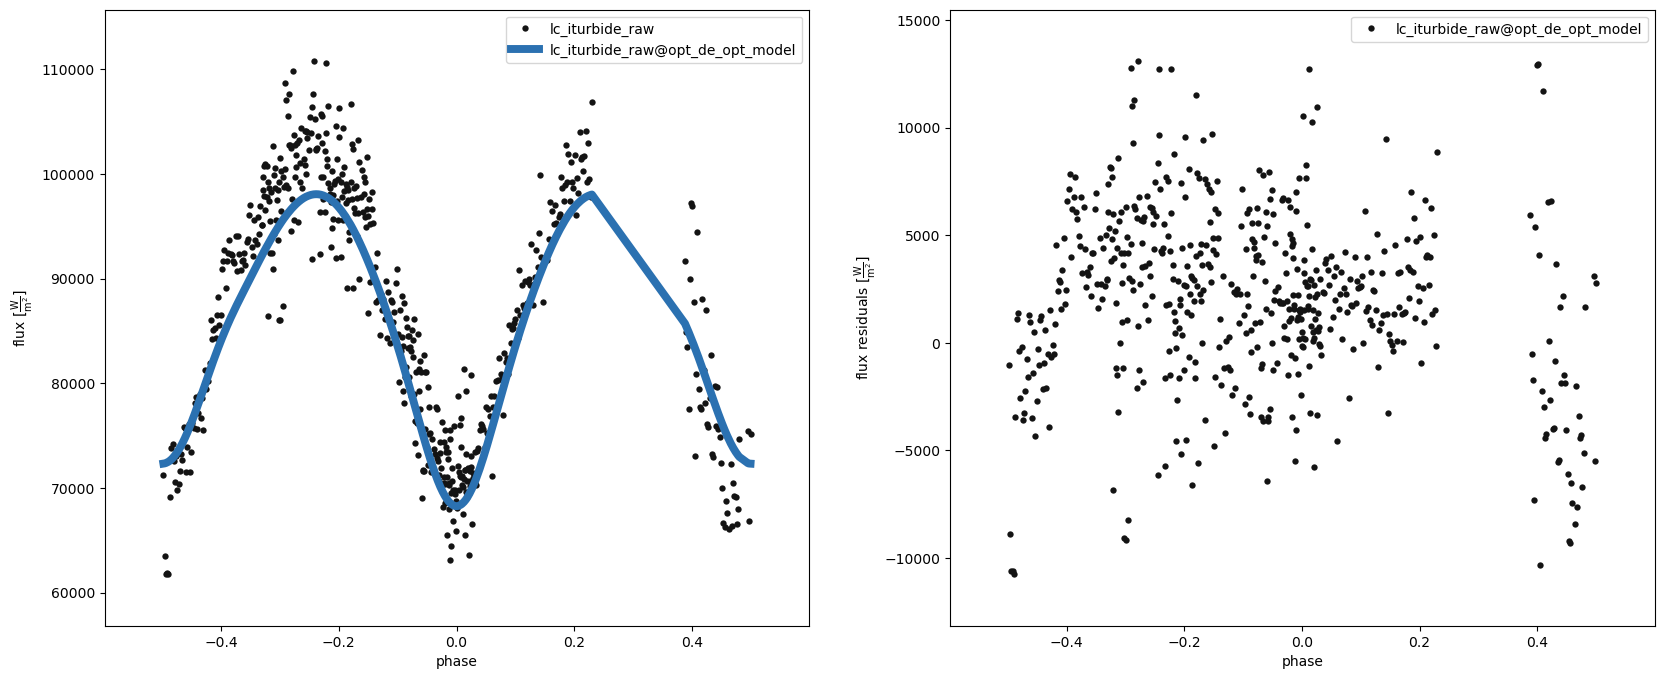

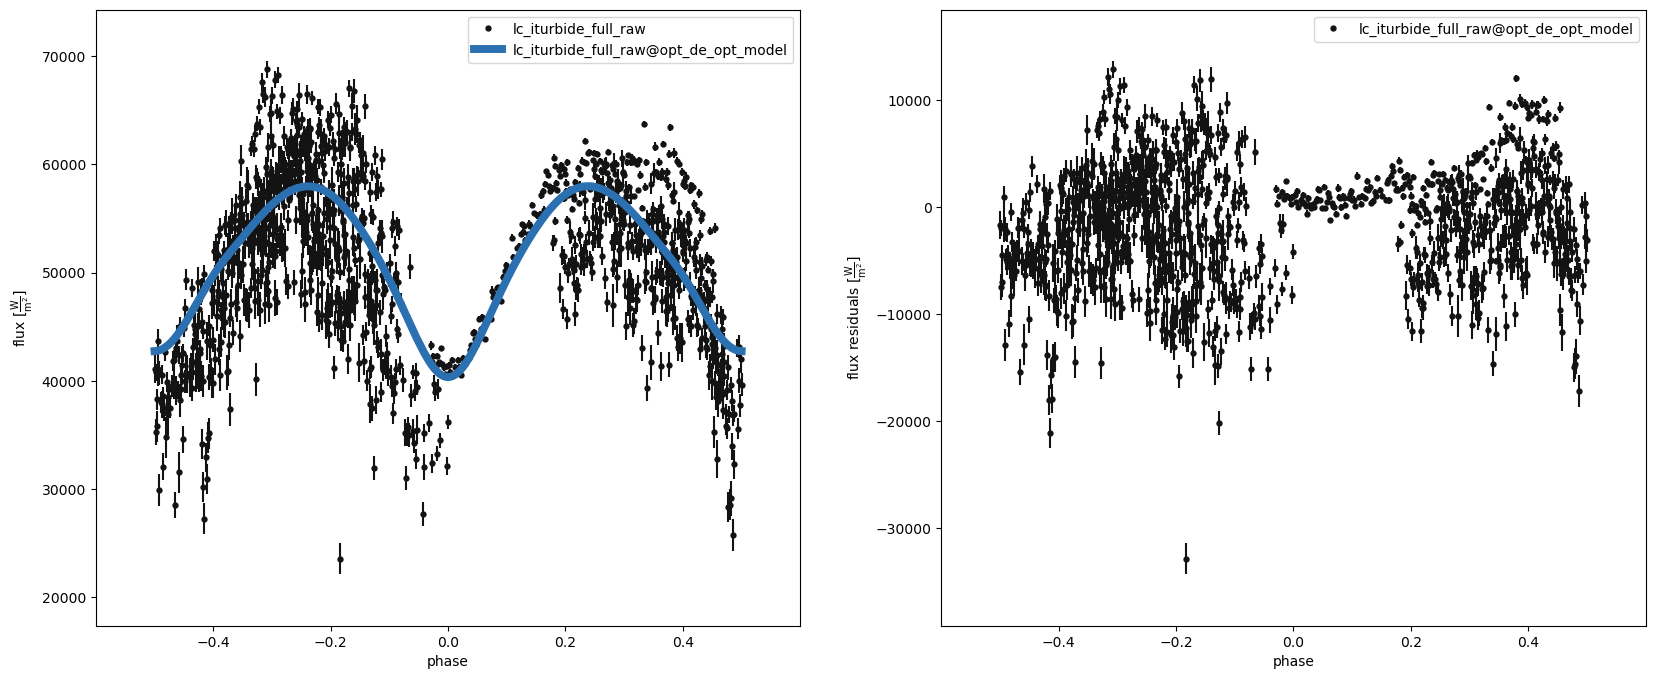

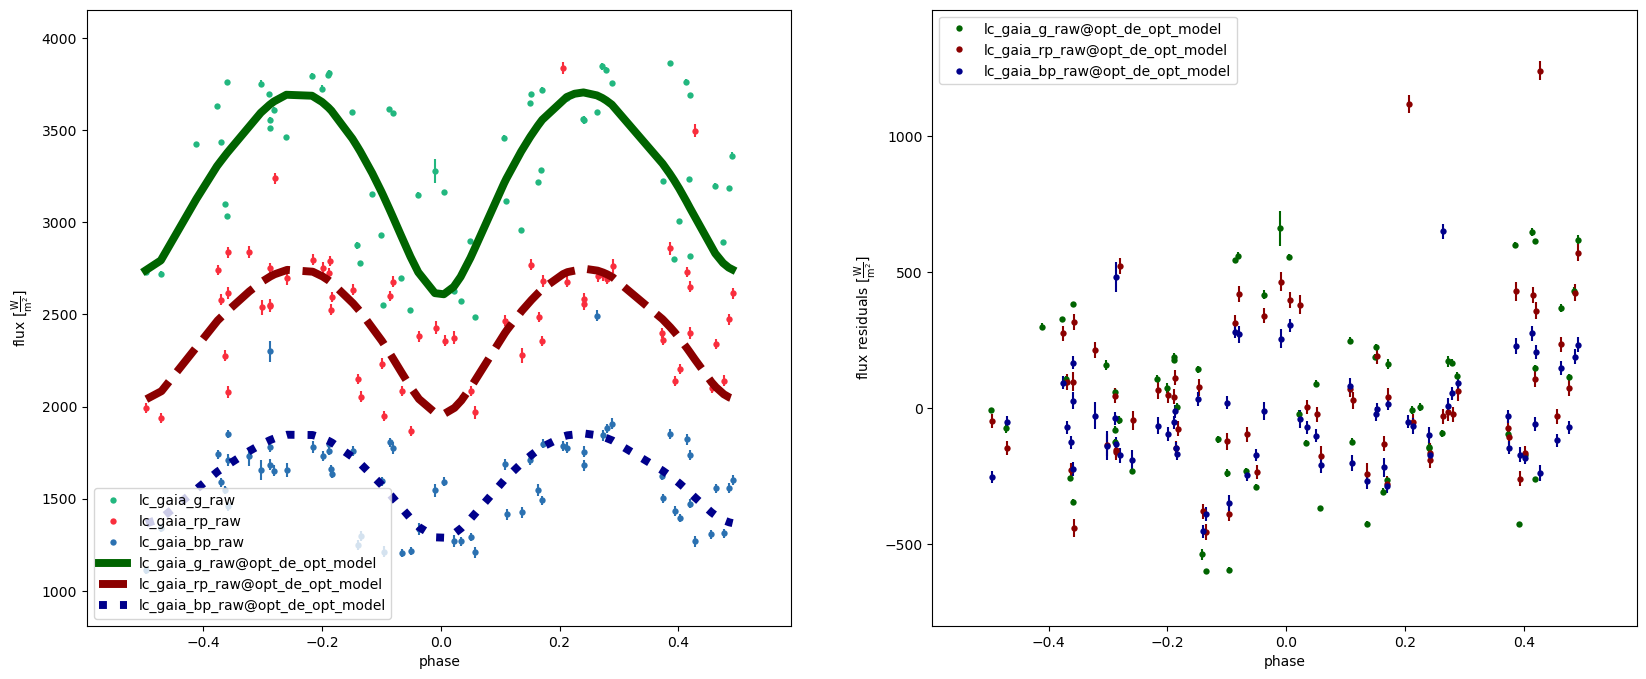

opt_de_opt_model
-------------------------------------
	 Iturbide (Aviles) - 11627411982.081367
	 Iturbide (Full) - 60359.30715667129
	 Gaia - 65304.36171628259
		 lc_gaia_g_raw - 55090.41602488377
		 lc_gaia_rp_raw - 6676.93261319238
		 lc_gaia_bp_raw - 3537.013078206435


In [36]:
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/aviles-invq/results/opt_de_opt_solution", plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=plotAllDatasetsGroups, model=computeModelName)
printChi2(b, computeModelName)

Sat, 18 Nov 2023 16:49 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_de_opt_full_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
teff@primary@star@component = 4316.31184 K
teffratio@binary@orbit@component = 0.98089 
mass@primary@star@component = 0.87552 solMass
q@binary@orbit@component = 0.25018 
fillout_factor@contact_envelope@envelope@component = 0.41451 
pblum@primary@lc_gaia_g_raw@lc@dataset = 30193.49469 W
pblum@primary@lc_iturbide_full_raw@lc@dataset = 563869.97571 W
pblum@primary@lc_iturbide_raw@lc@dataset = 952249.90532 W

Original values:
  teff@primary@star@component 4138.4308834938365 K
  teffratio@binary@orbit@component 0.9493072392967905
  mass@primary@star@component 1.0087816199638129 solMass
  q@binary@orbit@component 0.2861274842133835
  fillout_factor@contact_envelope@envelope@component 0.2034325452229504
  pblum@primary@lc_gaia_g_raw@lc@dataset 34979.800770998816 W
  pblum@primary@lc_iturbide_full_raw@lc@dataset 567161.6312684531 W
  pblum@primary@lc_iturbide_raw@lc@dataset 959718.3862413258 W


Sat, 18 Nov 2023 16:49 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Sat, 18 Nov 2023 16:49 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 1964/1964 [03:20<00:00,  9.78it/s]


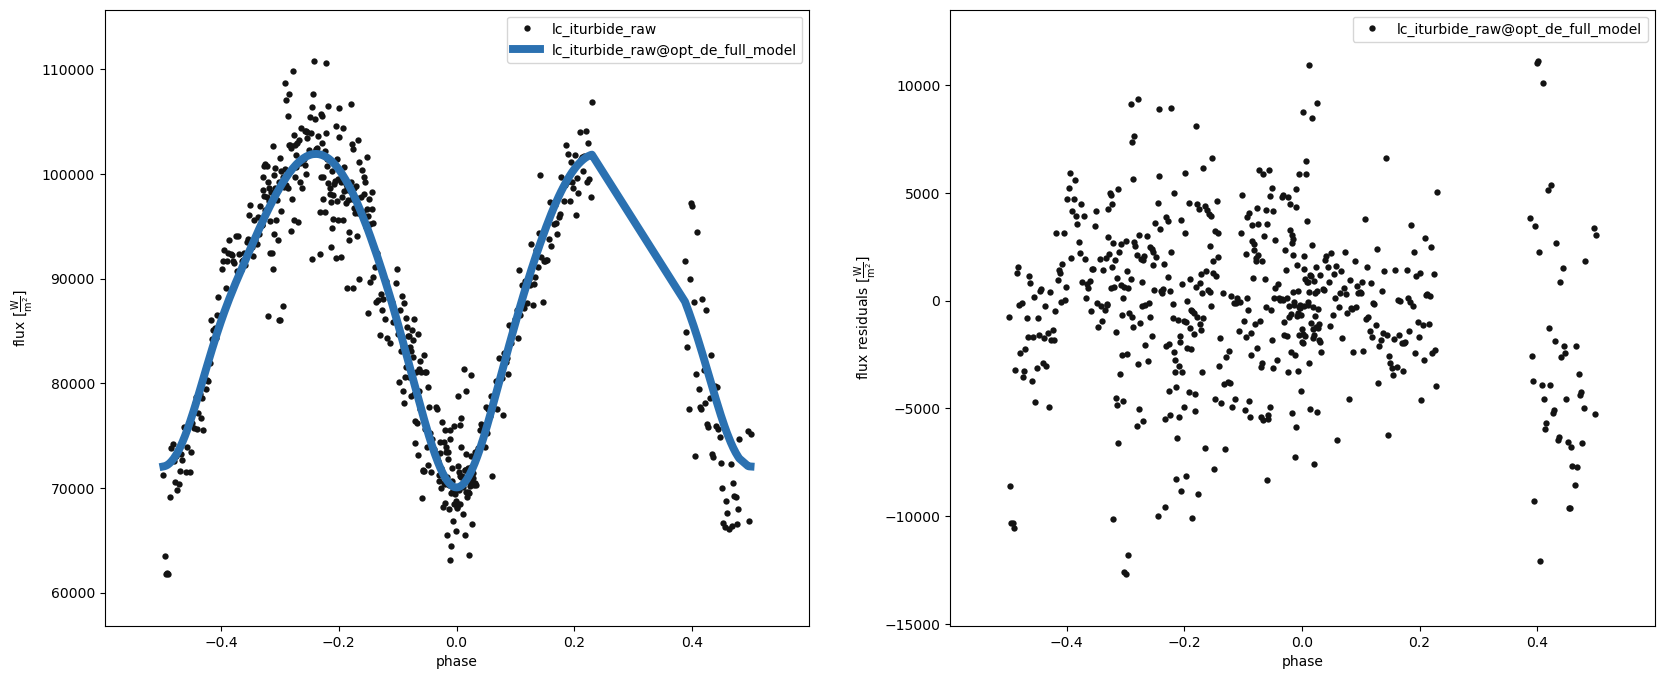

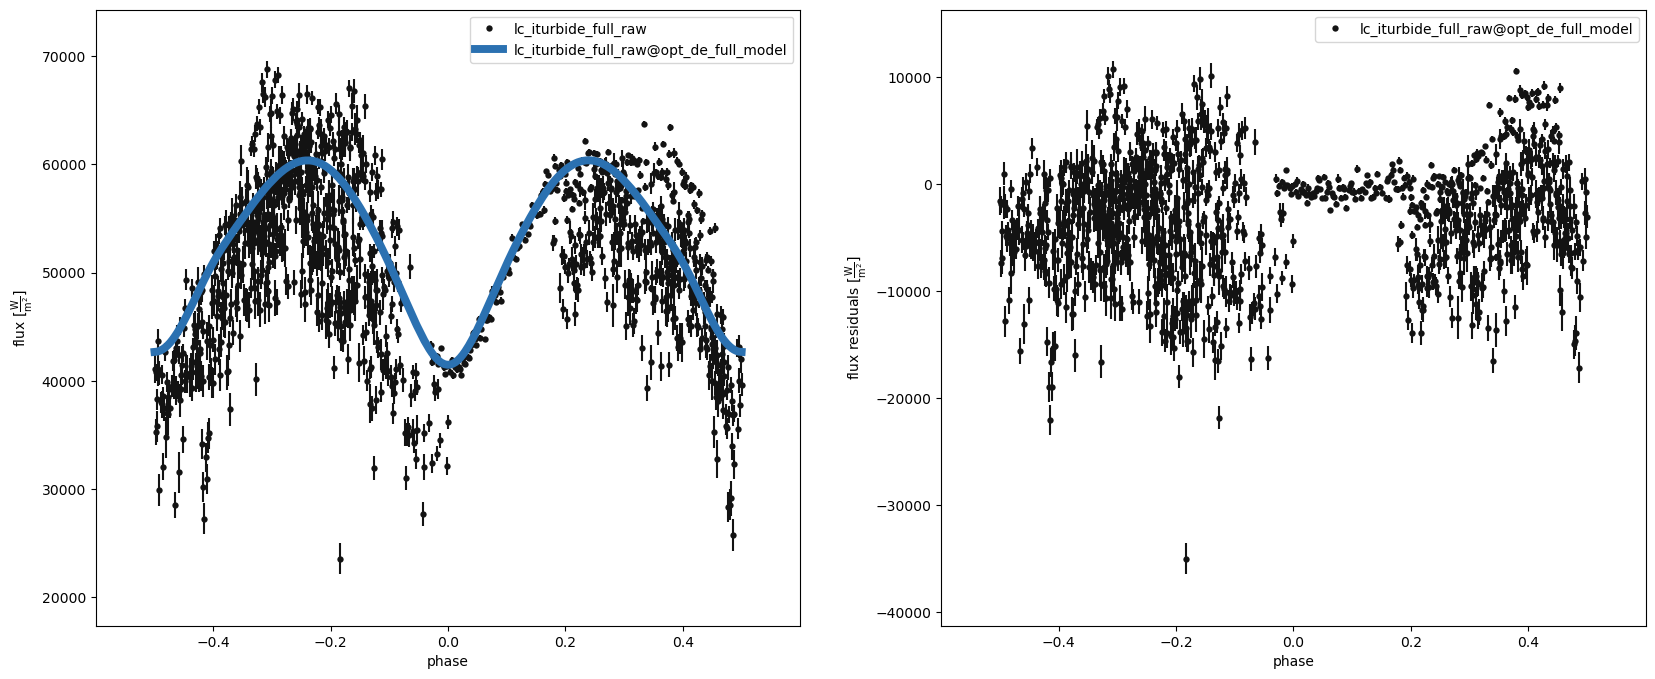

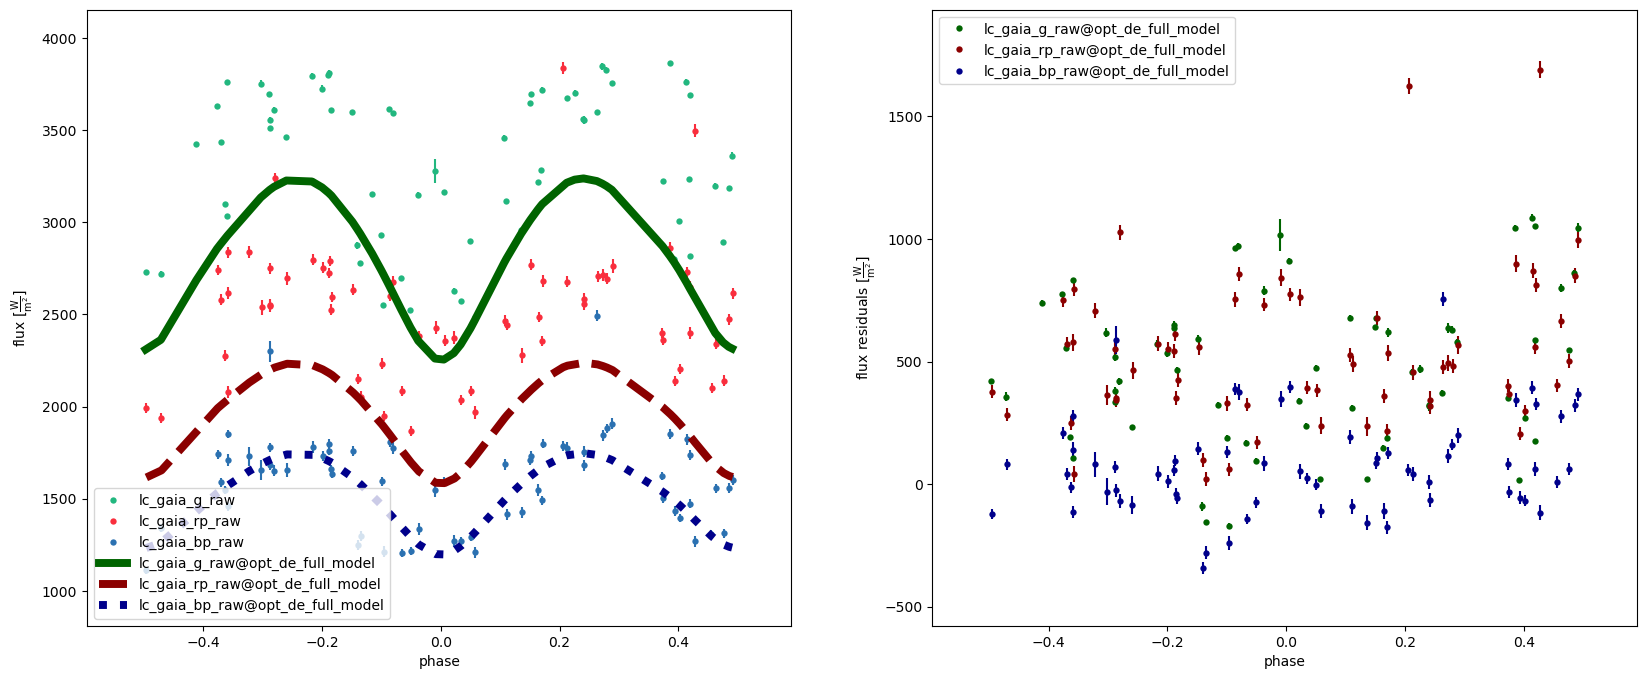

opt_de_full_model
-------------------------------------
	 Iturbide (Aviles) - 8023506807.873561
	 Iturbide (Full) - 55530.91342930276
	 Gaia - 189848.94771888867
		 lc_gaia_g_raw - 159924.1635185114
		 lc_gaia_rp_raw - 26155.813173353854
		 lc_gaia_bp_raw - 3768.9710270234273


In [37]:
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/aviles-invq/results/opt_de_opt_full_solution", plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=plotAllDatasetsGroups, model=computeModelName)
printChi2(b, computeModelName)

  2%|▏         | 3/200 [02:05<2:13:01, 40.51s/it]Thu, 16 Nov 2023 12:25 UNIVERSE     WARNING Atmosphere parameters out of bounds: Teff=[3491.54270297 3489.60666394 3493.31365621 3493.31365621 3493.31365621], logg=[3.69390997 3.69089896 3.69666276 3.69666276 3.69666276], abun=[0. 0. 0. 0. 0.]
Thu, 16 Nov 2023 12:25 SOLVER       WARNING received error from run_compute: Could not compute ldint with ldatm='ck2004'.  Try changing atm to a table that covers a sufficient range of values.  If necessary, set atm to 'blackbody' and/or ld_mode to 'manual' (in which case coefficients will need to be explicitly provided via ld_coeffs). Enable 'warning' logger to see out-of-bound arrays..  lnprobability=-inf
  2%|▏         | 4/200 [02:20<1:42:07, 31.26s/it]Thu, 16 Nov 2023 12:25 UNIVERSE     WARNING Atmosphere parameters out of bounds: Teff=[3427.29739685 3418.80222999 3435.36265622 3453.7910345  3440.929566
 3444.65514211 3468.88900481 3482.25629531 3416.90652511 3431.39259086
 3441.97976949 3447.9

Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset = 36322.20756 W
teff@primary@star@component = 4122.84167 K
teffratio@binary@orbit@component = 0.92872 

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 30338.60311322982 W
  teff@primary@star@component 4345.350056855733 K
  teffratio@binary@orbit@component 0.9745828830068449


100%|██████████| 213/213 [00:14<00:00, 14.48it/s]


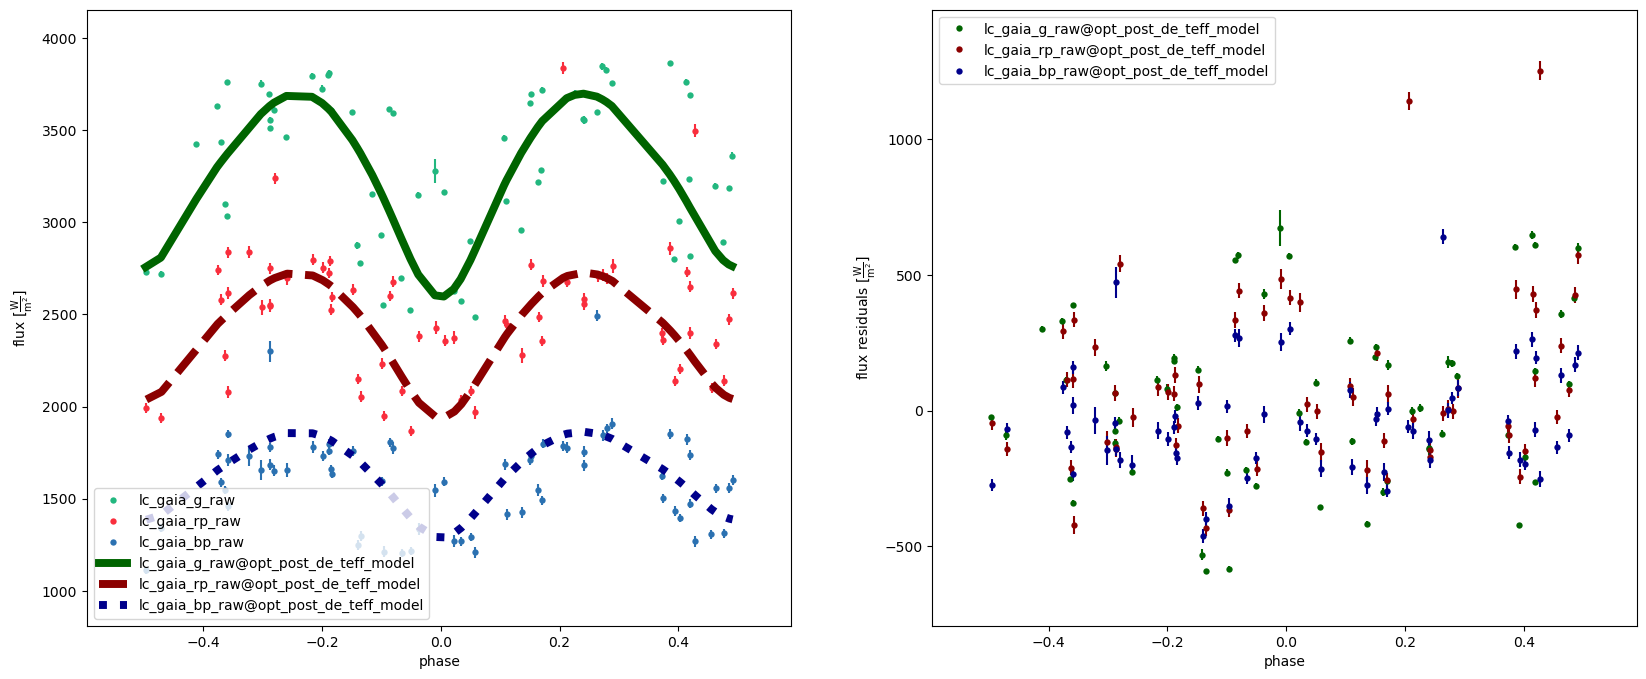

opt_post_de_teff_model
-------------------------------------
	 Gaia - 65043.95753934716
		 lc_gaia_g_raw - 54646.81984691751
		 lc_gaia_rp_raw - 6780.391755407513
		 lc_gaia_bp_raw - 3616.7459370221336


In [55]:
opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw', 'teff@primary@component', 'teffratio'], 'post_de_teff', 
						  export=False, datasets=rawGaiaDatasets, maxiter=200)
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, label='post_de_teff', reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [rawGaiaDatasets], computeModelName)
printChi2(b, computeModelName)

In [45]:
b.models

['full_default',
 'raw_model',
 'before_optimizers',
 'invq_before_opt',
 'opt_period_t0_model',
 'opt_teffr_ff_model',
 'opt_incl_model',
 'before_pb_opt_datasetscaled',
 'opt_tprim_tratio_pbgaia_model',
 'opt_pb_iturbide_aviles_model',
 'opt_pb_iturbide_full_model',
 'opt_de_opt_model',
 'opt_de_full_model']

In [46]:
printChi2(b, 'opt_de_opt_model')
printChi2(b, 'opt_de_full_model')
printChi2(b, 'opt_pb_iturbide_full_model')
printChi2(b, 'opt_pb_iturbide_aviles_model')
printChi2(b, 'opt_tprim_tratio_pbgaia_model')

opt_de_opt_model
-------------------------------------
	 Iturbide (Aviles) - 11627411982.081367
	 Iturbide (Full) - 60359.30715667129
	 Gaia - 65304.36171628259
		 lc_gaia_g_raw - 55090.41602488377
		 lc_gaia_rp_raw - 6676.93261319238
		 lc_gaia_bp_raw - 3537.013078206435
opt_de_full_model
-------------------------------------
	 Iturbide (Aviles) - 8140647915.693872
	 Iturbide (Full) - 54683.29002366199
	 Gaia - 193722.08936722047
		 lc_gaia_g_raw - 162440.28963612195
		 lc_gaia_rp_raw - 27610.26304344221
		 lc_gaia_bp_raw - 3671.536687656316
opt_pb_iturbide_full_model
-------------------------------------
	 Iturbide (Full) - 53752.020493084914
opt_pb_iturbide_aviles_model
-------------------------------------
	 Iturbide (Aviles) - 8861945173.751333
opt_tprim_tratio_pbgaia_model
-------------------------------------
	 Gaia - 65942.53492160157
		 lc_gaia_g_raw - 55184.81007549676
		 lc_gaia_rp_raw - 6995.286353295865
		 lc_gaia_bp_raw - 3762.4384928089466


## Final optimization results

Trimming and saving the bundle again to begin MCMC sampling.

In [ ]:
# removing all models so far; to avoid bloated bundle when saving and loading
b.remove_models_all(b.models)

<ParameterSet: 2154 parameters | contexts: figure, model>

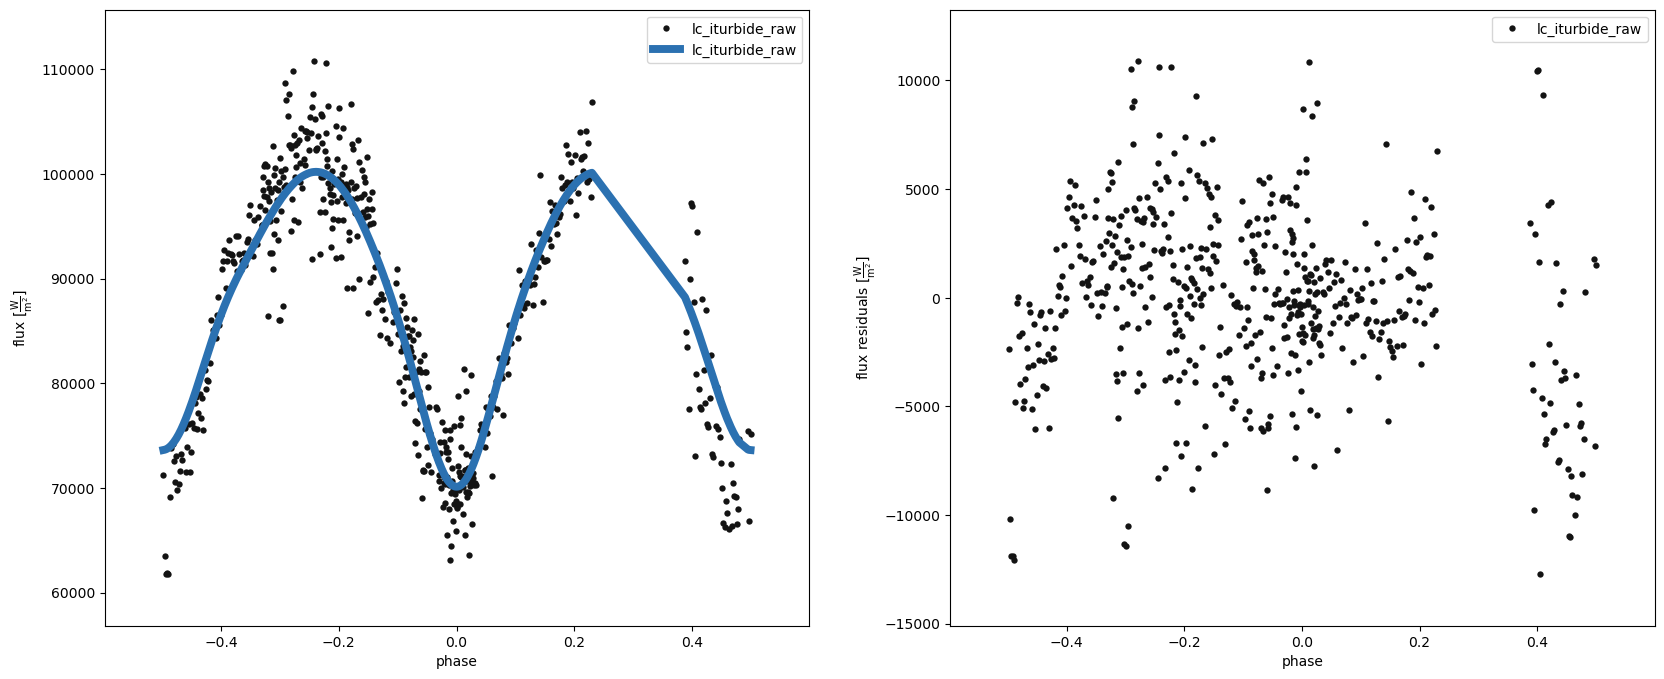

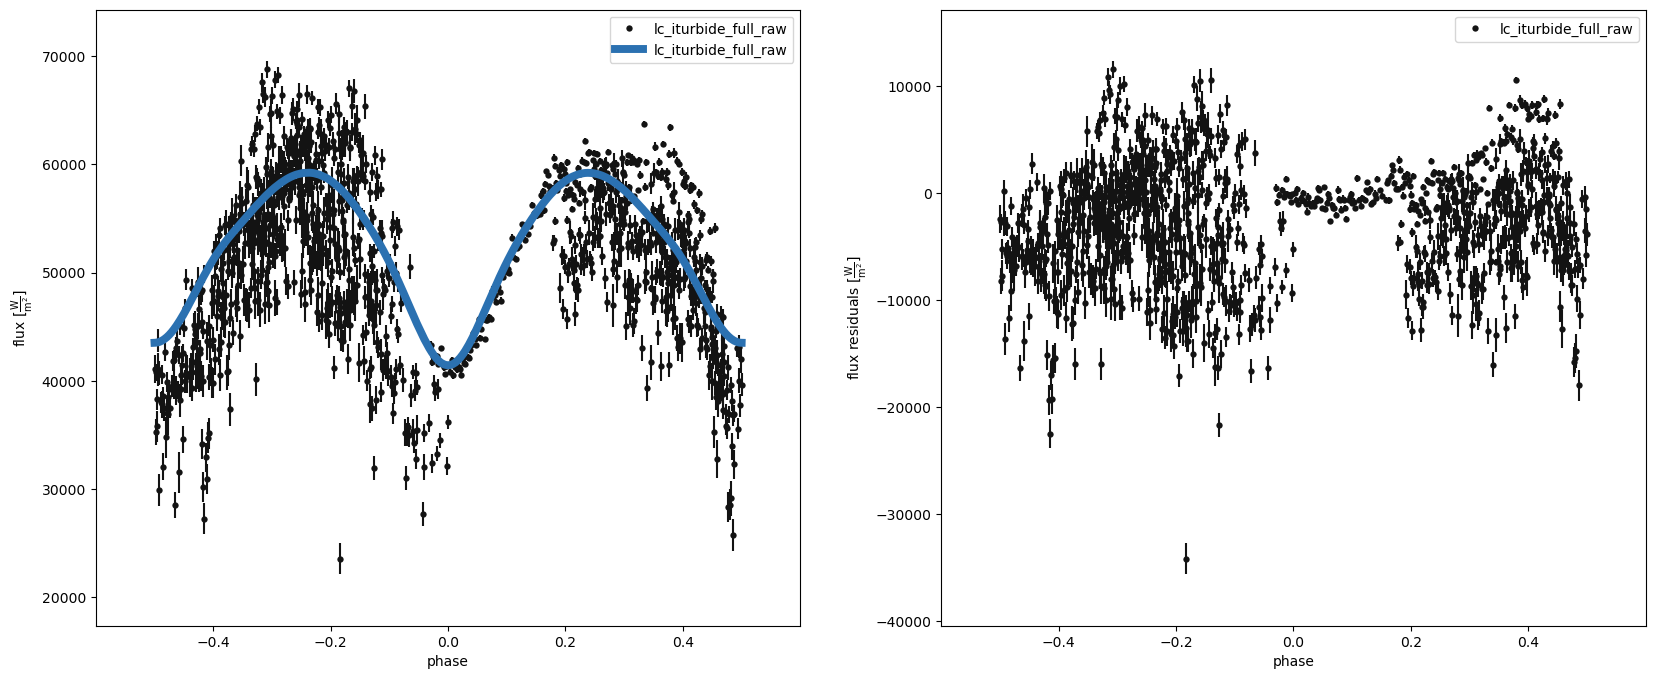

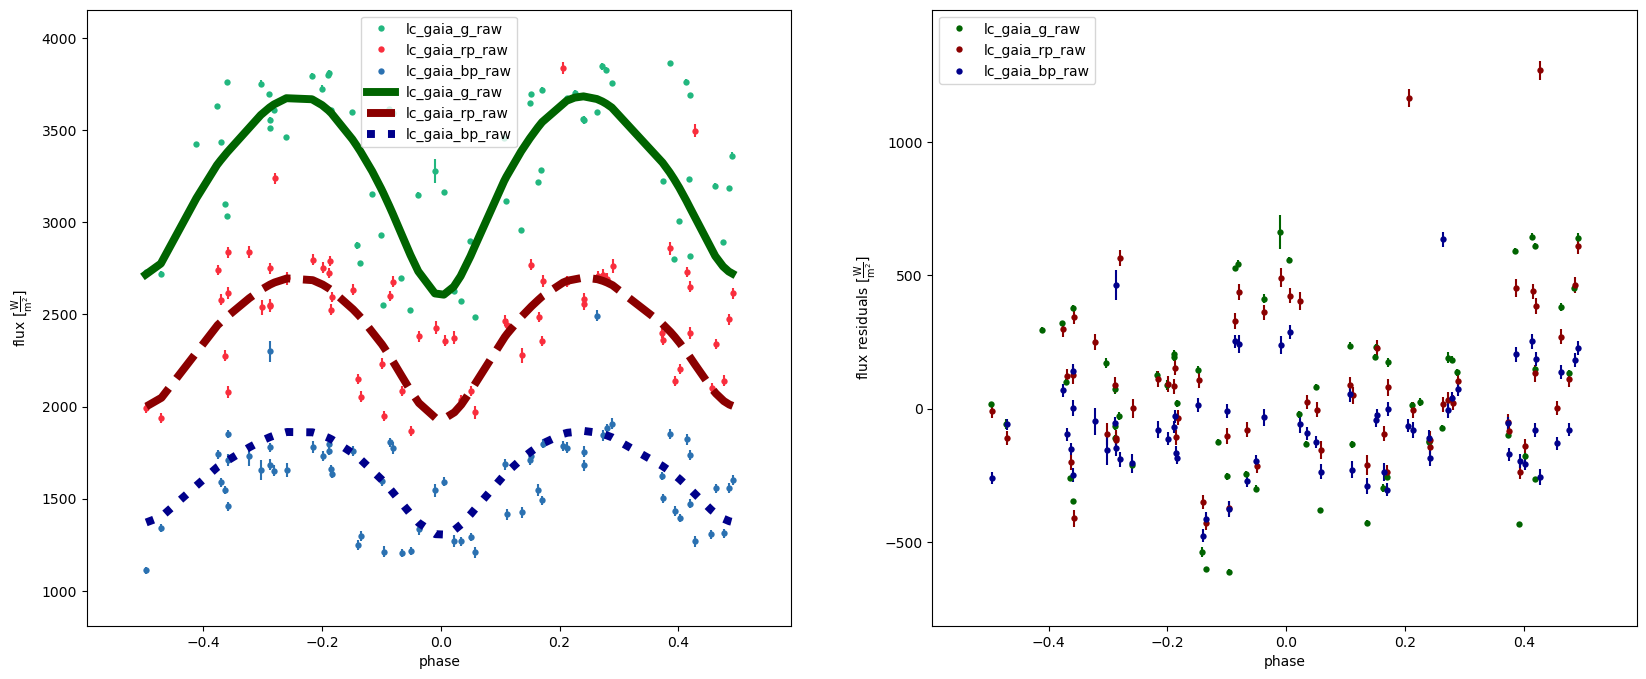

after_optimizers
-------------------------------------
	 Iturbide (Aviles) - 8861945173.751333
	 Iturbide (Full) - 53752.020493084914
	 Gaia - 65942.53492160157
		 lc_gaia_g_raw - 55184.81007549676
		 lc_gaia_rp_raw - 6995.286353295865
		 lc_gaia_bp_raw - 3762.4384928089466


In [ ]:
# running last model for reference in sampling run
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='after_optimizers', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model='after_optimizers')
printChi2(b, 'after_optimizers')

In [78]:
gen_utils.saveBundle(b, "after_optimizers", "poro-aviles-invq")

'bundle-saves/poro-aviles-invq/after_optimizers'

In [13]:
b = phoebe.load("./bundle-saves/poro-aviles-invq/after_optimizers")

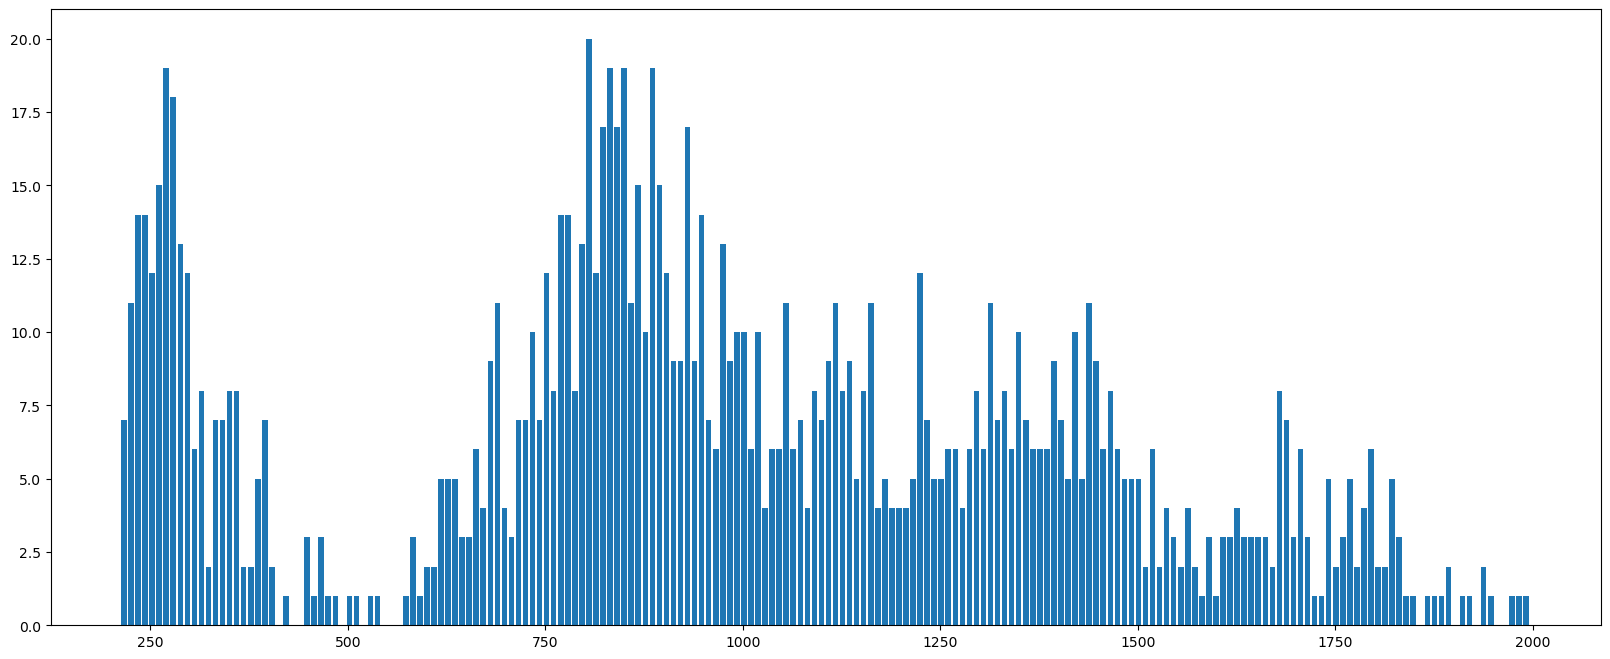

In [24]:
plt.figure(figsize=(20, 8))
_ = plt.hist(b['value@sigmas@lc_iturbide_full_raw@dataset'], bins=200, width=7)